In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# import pickle as pk
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from os import path
import sys
from mmctools.plotting import TaylorDiagram
from scipy.stats import pearsonr
import glob
from mmctools.wrf.utils import tsout_seriesReader
from mmctools.helper_functions import calc_wind,w_s,theta_to_T
from matplotlib.colors import Normalize
from string import ascii_lowercase
from matplotlib.legend_handler import HandlerBase

In [98]:
main_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/'
#main_directory = '/glade/work/hawbecke/MMC/NYSERDA/WRF/SENSITIVITY_SUITE/'

icbc_type = 'MERRA2'  # ERAI, ERA5, FNL

from NYSERDA_case_dict import case_dict

cases = [case_dict[x]['case_str'] for x in list(case_dict.keys())]

# TESTING:
cases = [cases[0]] + cases[3:6]# + [cases[-1]]

eta_level_testing = False
if eta_level_testing:
    main_directory += 'eta_level_test/'
    cases = cases[-3:]
    time_step = 5.0
else:
    cases = cases[:]
    failed_cases = []
    for case in failed_cases:
        cases.remove(case)
    time_step = 6.0

sim_start = '2020-04-04 06:00:00'
#case_start = '2020-04-05 16:00:00'
#case_end   = '2020-04-06 06:00:00'
case_start = '2020-04-06 01:00:00'
case_end   = '2020-04-06 06:00:00'

best_case  = 'WPS3_WRF1'
n_profiles = 8

dom_dict = {1: {'dt':15,
                'marker': r'$ 1 $',
                'ls':'-'},
            2: {'dt':5,
                'marker': r'$ 2 $',
                'ls':'--'},
            3: {'dt':1,
                'marker': r'$ 3 $',
                'ls':'-'},
            4: {'dt':0.2,
                'marker': r'$ 4 $',
                'ls':'-.'},
            5: {'dt':0.04,
                'marker': r'$ 5 $',
                'ls':':'},
            }
doms_of_interest = [1,2,3,4,5]

#for cc,case in enumerate(cases):
#    plt.plot(np.arange(0,10),np.arange(0,10)*cc,c=case_dict[case]['color'])

# Get Obs:

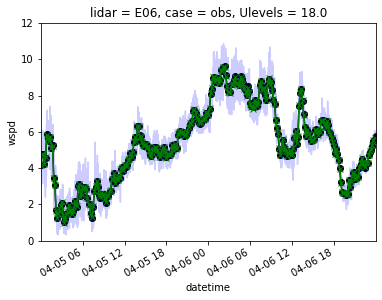

In [5]:
obs_dir = '/glade/work/hawbecke/MMC/NYSERDA/obs/'
obs_res = 'high' # 'low' or 'high'
atlshrs_full = xr.open_dataset('{}ATLSHORES_lidars.nc'.format(obs_dir))
atlshrs_obs = atlshrs_full.sel(case='obs').squeeze(dim='Tlevels')
atlshrs_obs.T.data += 273.15
atlshrs_obs.sst.data += 273.15

if obs_res == 'low':
    nyserda_full = xr.open_dataset('{}NYSERDA_lidars.nc'.format(obs_dir))
    nyserda_obs = nyserda_full.sel(case='obs')
    
    #best_case = 'WPS3_WRF1'
    #nyserda_opt = nyserda_full.sel(case=best_case)
    hr_nyserda_obs = xr.open_dataset('{}HR_NYSERDA_lidars.nc'.format(obs_dir))
else:
    lr_nyserda_obs = xr.open_dataset('{}NYSERDA_lidars.nc'.format(obs_dir))
    lr_nyserda_obs = lr_nyserda_obs.sel(case='obs',Tlevels=2).drop('Tlevels')

    nyserda_obs = xr.open_dataset('{}HR_NYSERDA_lidars.nc'.format(obs_dir))
    nyserda_obs = nyserda_obs.drop('T')
    nyserda_obs = nyserda_obs.squeeze().drop('Tlevels')

    sst = lr_nyserda_obs.sst.sel(datetime=slice(nyserda_obs.datetime[0],nyserda_obs.datetime[-1]))
    nyserda_obs = xr.merge([nyserda_obs,sst])
    t2 = lr_nyserda_obs.T.sel(datetime=slice(nyserda_obs.datetime[0],nyserda_obs.datetime[-1])).squeeze()
    nyserda_obs = xr.merge([nyserda_obs,t2])

    lr_nyserda_obs.wspd.sel(Ulevels=20,lidar='E06').plot(c='k',marker='o')
    nyserda_obs.wspd.sel(Ulevels=18,lidar='E06').dropna(how='any',dim='datetime').plot(c='b',alpha=0.2)
    nyserda_obs.wspd.sel(Ulevels=18,lidar='E06').resample({'datetime':'10min'}).mean().plot(c='g',marker='x')
    plt.xlim(pd.to_datetime(nyserda_obs.datetime.data[0]),pd.to_datetime(nyserda_obs.datetime.data[-1]))
    plt.ylim(0,12)

# Get WRF for multiple domains:

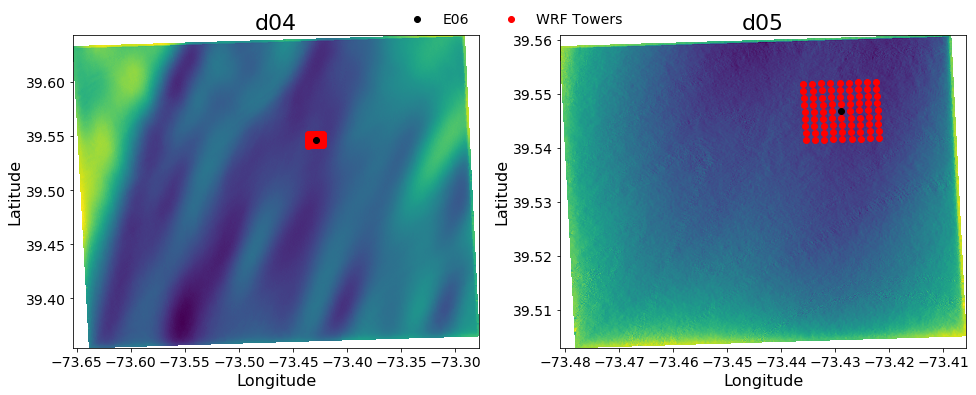

In [51]:
wrf_data = {}
avg_twr_dict = {}

doms = [1,2,3,4,5]


show_plot = True

twr_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/tower_netCDFs/'

cases_of_interest = cases.copy()

for dd,dom in enumerate(doms):
    
    time_step = dom_dict[dom]['dt']
    dom_str = 'd0{}'.format(dom)

    for cc,case in enumerate(cases):
        if dd == 0:
            wrf_data[case] = {}
            avg_twr_dict[case] = {}
        #tower_f = '{0}{1}/NYSERDA_{1}_towers_{2}.nc'.format(main_directory,case,dom_str)
        if dom in [1,2]:
            tower_f = '{0}NYSERDA_{1}_towers_{2}.nc'.format(twr_directory,case,dom_str)
        else:
            tower_f = '{0}NYSERDA_{1}_towers_{2}_avg.nc'.format(twr_directory,case,dom_str)

        if path.exists(tower_f):
            wrf_data[case][dom_str] = xr.open_dataset(tower_f)
        else:
            print('Please run ConvertTSLISTtoNetCDF.py to get tslist output for {} {}'.format(case,dom_str))
                
        if (cc == 0) and (dom == 5) and (show_plot):
            fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(16,8))
            for dd,dom in enumerate([4,5]):
                dom_str_plt = 'd0{}'.format(dom)
                wrfout_dir = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/MERRA2_DFLT_NOSK_CHRN_MDIS/'
                wrfout_f = '{}wrfout_d0{}_2020-04-06_04:00:00'.format(wrfout_dir,dom)
                wrfout = xr.open_dataset(wrfout_f).squeeze()
                wrf_lon = wrfout.XLONG
                wrf_lat = wrfout.XLAT
                wrf_var_to_plot = wrfout.U10#.sel(bottom_top=40)
                
                if dom == 4:
                    temp_twr_ds = xr.open_dataset('{0}NYSERDA_{1}_towers_d04.nc'.format(twr_directory,case))
                else:
                    temp_twr_ds = xr.open_dataset('{0}NYSERDA_{1}_towers_d05_chunk0.nc'.format(twr_directory,case))

                ax[dd].pcolormesh(wrf_lon,wrf_lat,wrf_var_to_plot)

                for ss,stn in enumerate(temp_twr_ds.station):
                    if 'T' == str(stn.data)[0]:
                        i = int(temp_twr_ds.sel(station=stn).i)-1
                        j = int(temp_twr_ds.sel(station=stn).j)-1
                        lon = wrf_lon.sel(west_east=i,south_north=j)
                        lat = wrf_lat.sel(west_east=i,south_north=j)
                        if ss == 1:
                            stn_lbl = 'WRF Towers'
                        else:
                            stn_lbl = None
                        ax[dd].scatter(lon,lat,c='r',label=stn_lbl)
                    elif str(stn.data) == 'E06':
                        i = int(temp_twr_ds.sel(station=stn).i)-1
                        j = int(temp_twr_ds.sel(station=stn).j)-1
                        lon = wrf_lon.sel(west_east=i,south_north=j)
                        lat = wrf_lat.sel(west_east=i,south_north=j)
                        ax[dd].scatter(lon,lat,c='k',label='E06',zorder=1000)

                ax[0].legend(frameon=False,fontsize=14,ncol=2,loc=(0.8,1.01))
                ax[dd].tick_params(labelsize=14)
                ax[dd].set_aspect('equal')
                span = 0.017
                x_s = -73.438
                y_s = 39.538

                ax[dd].set_xlabel('Longitude',size=16)
                ax[dd].set_ylabel('Latitude',size=16)
                ax[dd].set_title(dom_str_plt,size=22)

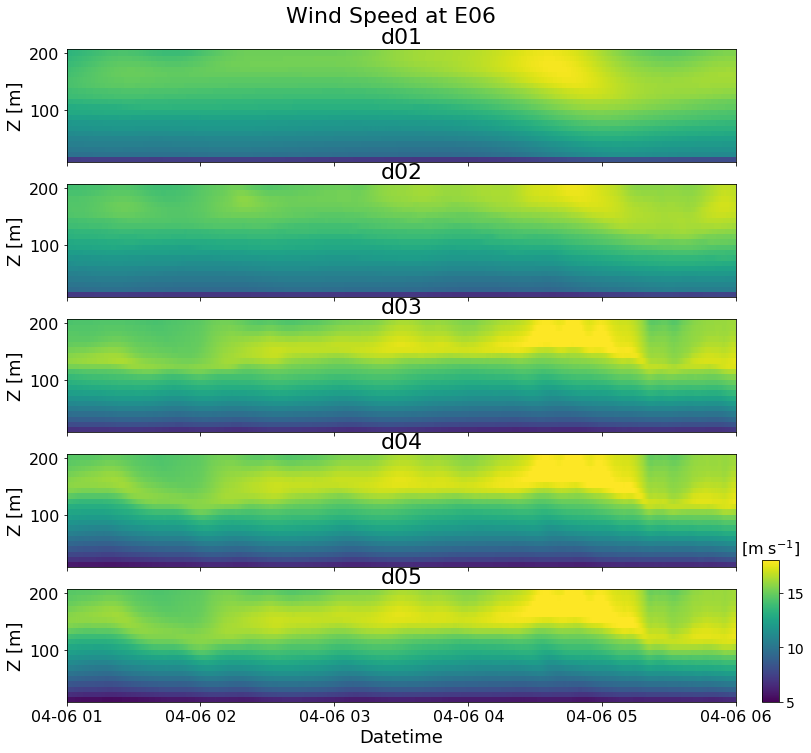

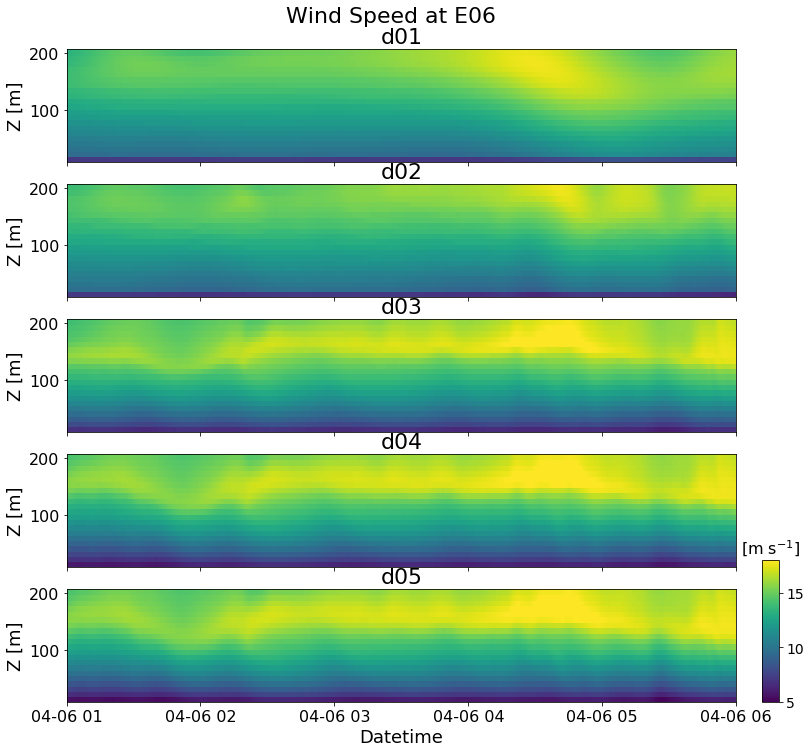

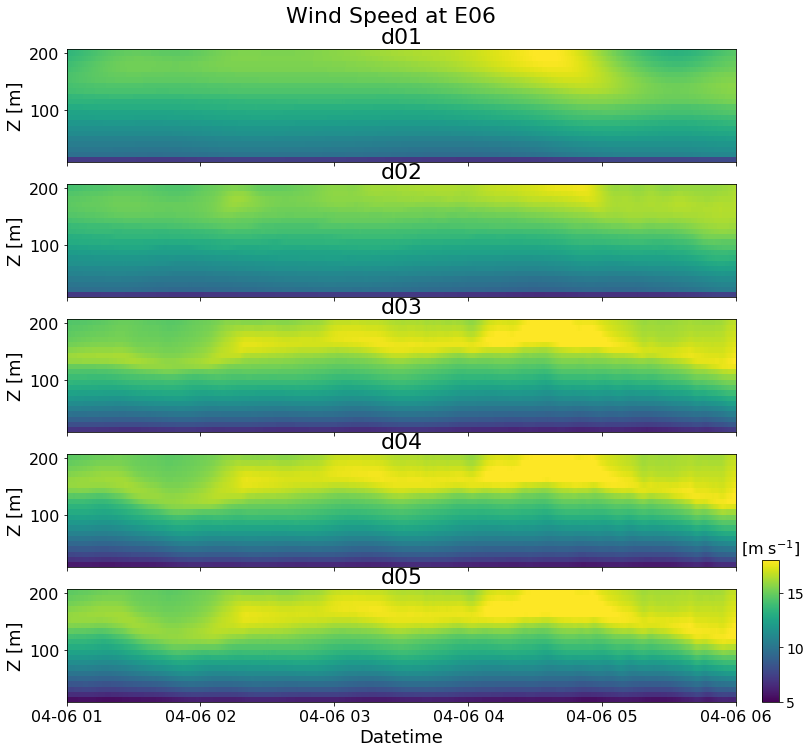

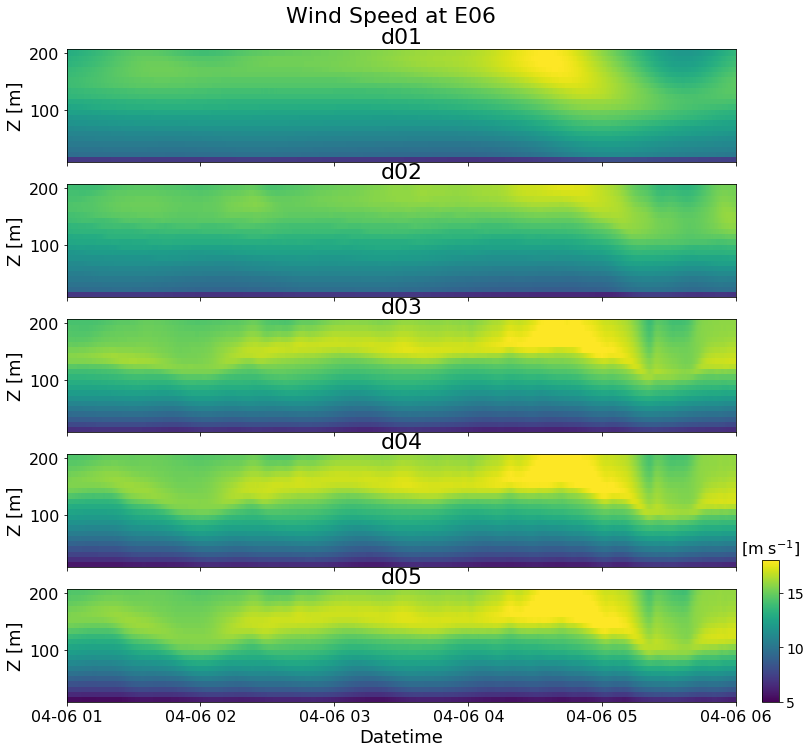

In [53]:
for cc,case in enumerate(cases):
    nrows = len(wrf_data[case].keys())
    fig,ax = plt.subplots(nrows=nrows,figsize=(12,12),sharex=True)
    for dd,dom_str in enumerate(list(wrf_data[case].keys())):
        if ('d04' in dom_str) or ('d05' in dom_str):
            twr = wrf_data[case][dom_str].sel(station='E06',nz=slice(0,22),datetime=slice(case_start,case_end))
        else:
            twr = wrf_data[case][dom_str].sel(station='E06',nz=slice(0,22),datetime=slice(case_start,case_end))

        z = twr.ph.mean(dim='datetime').data
        t = twr.datetime.data

        tz,zt = np.meshgrid(t,z)
        twr_plt = ax[dd].pcolormesh(tz,zt,twr.wspd.T,vmin=5,vmax=18)

        ax[dd].tick_params(labelsize=16)
        ax[dd].set_title(dom_str,size=22)
        ax[dd].set_ylabel('Z [m]',size=18)
    ax[nrows-1].set_xlabel('Datetime',size=18)

    cax  = fig.add_axes([0.93,0.125,0.02,0.164])
    cbar = plt.colorbar(twr_plt,cax=cax)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_title('[m s$^{-1}$]',size=16)
    plt.suptitle('Wind Speed at E06',size=22,y=0.93)
    plt.show()

# Combine WRF and obs and resample to obs time:

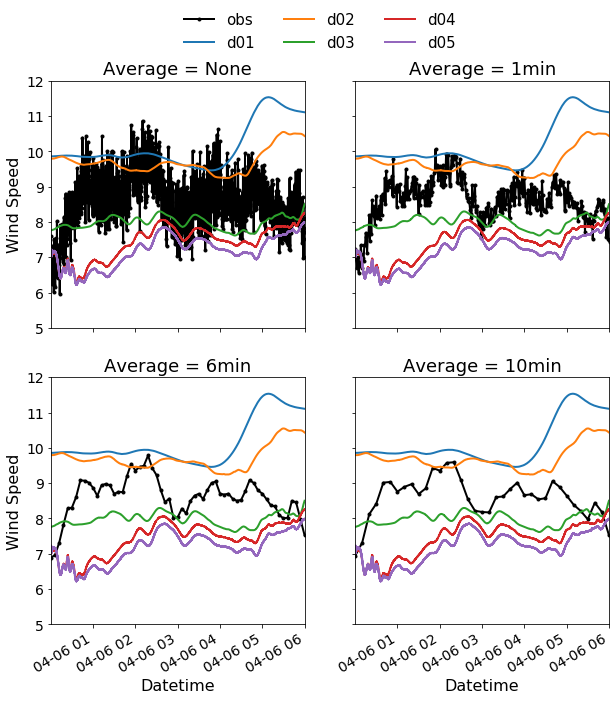

In [54]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,10),sharex=True,sharey=True)
row,col = 0,0
for rr,res in enumerate([None,'1min','6min','10min']):
    if res is None:
        obs = nyserda_obs.wspd.sel(Ulevels=18.0,lidar='E06').dropna(how='any',dim='datetime')
    else:
        obs = nyserda_obs.wspd.sel(Ulevels=18.0,lidar='E06').resample({'datetime':res}).mean()
    
    #print(obs.sel(datetime=pd.to_datetime('2020-04-06 04:00:00.00'),method='nearest'))
    obs.plot(ax=ax[row,col],c='k',label='obs',lw=2.0,marker='.')

    for dd,dom in enumerate(doms):
        dom_str = 'd0{}'.format(dom)
        twr = wrf_data[cases[0]][dom_str].sel(station='E06',nz=1).wspd
        twr.plot(ax=ax[row,col],lw=2.0,label=dom_str)
        #pstart = max([obs.datetime.data[0],twr.datetime.data[0]])
    ax[row,col].set_title('Average = {}'.format(res),size=18)
    ax[row,col].tick_params(labelsize=14)
    if row == 1:
        ax[row,col].set_xlabel('Datetime',size=16)
    else:
        ax[row,col].set_xlabel('')
        
    if col == 0:
        ax[row,col].set_ylabel('Wind Speed',size=16)
    else:
        ax[row,col].set_ylabel('')
    col += 1
    if col == 2:
        col = 0
        row += 1
pstart = np.datetime64('2020-04-06 00:00:15.040000000')
pend = twr.datetime.data[-1]
plt.xlim(pstart,pend)
plt.ylim(5,12)

ax[0,0].legend(frameon=False,loc=(0.5,1.1),ncol=3,fontsize=15)
plt.show()


In [55]:
data_ds_fname = '{}lidar_sim_and_obs_d01.nc'.format(main_directory)

resample_time = '6min'
if resample_time is not None:
    data_ds_fname = data_ds_fname.replace('.nc','_res{}.nc'.format(resample_time))

if path.exists(data_ds_fname):
    print('Loading in {}'.format(data_ds_fname))
    lidar_ds_full = xr.open_dataset(data_ds_fname)
else:
    print('Resampling WRF and packaging into {}'.format(data_ds_fname))
    lidar_ds = xr.merge([atlshrs_obs,nyserda_obs])
    
    if resample_time is not None:
        lidar_ds = lidar_ds.resample({'datetime':resample_time}).mean()
        
    lidar_ds = lidar_ds.sel(datetime=slice(case_start,case_end))
    have_seconds = False
    for dd in lidar_ds.datetime.data:
        if pd.to_datetime(dd).second != 0: have_seconds = True
    if have_seconds: 
        time_str = 's'
        time_fact = 1.0
    else:
        time_str = 'min'
        time_fact = 60.0
    lidar_obs_dt = pd.to_timedelta(np.min(lidar_ds.datetime.data[1:] - lidar_ds.datetime.data[:-1]))
    lidar_obs_dt_str = '{}{}'.format(int(lidar_obs_dt.total_seconds()/time_fact),time_str)
    lidar_ds['t2'] = lidar_ds.T
    lidar_ds = lidar_ds.drop(['T','relh'])
    lidar_ds = lidar_ds.rename({'sst':'tsk','lidar':'station','Ulevels':'level'}).expand_dims(dim='case')

    init_full_ds = True
    for cc,case in enumerate(cases):
        print('Starting ' + case)
        for dd,dom in enumerate(doms):
            dom_str = 'd0{}'.format(dom)
            print(dom_str)
            case_str = '{}_{}'.format(case,dom_str)
            stations_available = wrf_data[case][dom_str].station
            wrf_ds = wrf_data[case][dom_str]

            wrf_ds = wrf_ds.sel(datetime=slice(case_start,case_end))
            wrf_dt = pd.to_timedelta((wrf_ds.datetime.data[1] - wrf_ds.datetime.data[0]))#.total_seconds()

            if wrf_dt < lidar_obs_dt:
                wrf_ds = wrf_ds.sel(station=stations_available).resample({'datetime':lidar_obs_dt_str}).mean()
            else:
                wrf_ds = wrf_ds.sel(station=stations_available).resample({'datetime':lidar_obs_dt_str}).nearest()
            wrf_ds['T'] = theta_to_T(wrf_ds.theta,wrf_ds.pr/100.0)
            wrf_ds['nz'] = wrf_ds.ph.mean(dim=['datetime','station'])
            wrf_ds = wrf_ds.drop(['k','zsurface']).rename({'nz':'level'})
            #wrf_ds['RH'] = wrf_ds.qv.data/w_s(wrf_ds.T,wrf_ds.pr/100.0)
            wrf_ds['wspd10'],wrf_ds['wdir10'] = calc_wind(wrf_ds,u='u10',v='v10')
            ws10 = wrf_ds['wspd10'].expand_dims(dim='level').assign_coords({'level':[10.0]})
            ws10.name = 'wspd'
            wrf_ds = xr.merge([wrf_ds,ws10])
            
            wd10 = wrf_ds['wdir10'].expand_dims(dim='level').assign_coords({'level':[10.0]})
            wd10.name = 'wdir'
            wrf_ds = xr.merge([wrf_ds,wd10])
            
            wrf_ds = wrf_ds[['wspd','wdir','w','t2','tsk']]
            wrf_ds = wrf_ds.expand_dims(dim='case').assign_coords({'case':[case_str]})
            #wrf_ds = wrf_ds.expand_dims(dim='dom').assign_coords({'dom':[dom]})
            wrf_ds = wrf_ds.interp(coords={'level':lidar_ds.level},method='linear')
            if init_full_ds:
                wrf_ds_res = wrf_ds
                init_full_ds = False
            else:
                wrf_ds_res = wrf_ds_res.combine_first(wrf_ds)
                del(wrf_ds)


    lidar_ds_full = xr.merge([wrf_ds_res,lidar_ds])
    lidar_ds_full.to_netcdf(data_ds_fname)

Loading in /glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/lidar_sim_and_obs_d01_res6min.nc


In [56]:
for case in cases:
    print(case)
    for key in list(avg_twr_dict[case].keys()):
        wrf_data[case][key] = avg_twr_dict[case][key]

    print(wrf_data[case]['d05'].datetime.data[0],wrf_data[case]['d05'].datetime.data[-1])
    print()

MERRA2_DFLT_NOSK_CHRN_MDIS
2020-04-06T00:00:15.040000000 2020-04-06T06:00:00.000000000

MERRA2_MURS_NOSK_CHRN_MDIS
2020-04-06T00:00:15.040000000 2020-04-06T06:00:00.000000000

MERRA2_NAVO_NOSK_CHRN_MDIS
2020-04-06T00:00:15.040000000 2020-04-06T06:00:00.000000000

MERRA2_OSTI_NOSK_CHRN_MDIS
2020-04-06T00:00:15.040000000 2020-04-06T06:00:00.000000000



In [57]:
def TaylorDiagramData(obs_ds=None,
                      sim_ds=None,
                      TD_dim='datetime',
                      average_dim=None,
                      members_dim=None,
                      TD_variables=None):
    
    sim_dims = list(sim_ds.dims.keys())
    
    
    TD_stats_dict = {}
    for dim_to_drop in [TD_dim,average_dim,members_dim]:
        try:
            sim_dims.remove(dim_to_drop)
        except ValueError:
            print('members_dim: "{}" is not in the sim ds... setting to None'.format(dim_to_drop))
            members_dim = None

    obs_dims = list(obs_ds.dims.keys())
    for dim_to_drop in [TD_dim,average_dim]:
        obs_dims.remove(dim_to_drop)

    
    if len(sim_dims) > 0:
        raise ValueError( 'Too many dimensions in the sim data... please select data for {}'.format(sim_dims))
    if len(obs_dims) > 0:
        raise ValueError( 'Too many dimensions in the obs data... please select data for {}'.format(sim_dims))

    
    for TD_var in TD_variables:
        obs_da = obs_ds[TD_var]
        
        levels = obs_da[average_dim].values
        min_points = 0
        good_levels = []
        for k,lvl in enumerate(levels):
            num_points = len(obs_da.sel({average_dim:lvl}).dropna(how='all',dim=TD_dim))
            if num_points > min_points:
                good_levels.append(lvl)

        if members_dim is not None:
            cases = sim_ds[members_dim]
        else:
            sim_ds = sim_ds.assign_coords({'case':'A'}).expand_dims({'case':1})
            cases = sim_ds.case
        ncases = len(cases)

        tay_obs_levels = [[[]]*len(good_levels)][0]
        rms_levels = np.zeros((ncases,len(good_levels)))
        ref_std_levels = np.zeros((ncases,len(good_levels)))
        sim_std_levels = np.zeros((ncases,len(good_levels)))
        sim_cor_levels = np.zeros((ncases,len(good_levels)))
        sim_bia_levels = np.zeros((ncases,len(good_levels)))
        
        
        for cc,case in enumerate(cases):
            twr_ds = sim_ds.sel({members_dim:case})[TD_var]

            wrf_levels = sim_ds.level
            tay_wrf_levels = [[[]]*len(good_levels)][0]
            for vv,lvl in enumerate(good_levels):

                tay_obs_levels[vv] = obs_da.sel({average_dim:lvl}).dropna(how='all',dim=TD_dim)

                tay_wrf_levels[vv] = twr_ds.sel(level=lvl).dropna(how='all',dim=TD_dim)

                obs = tay_obs_levels[vv]
                sim = tay_wrf_levels[vv]

                sim[np.where(np.isnan(obs))] = np.nan
                obs = obs.dropna(dim=TD_dim,how='all')
                sim = sim.dropna(dim=TD_dim,how='all')
                
                if len(obs) != len(sim):
                    sim = sim.sel({TD_dim:slice(obs[TD_dim][0],obs[TD_dim][-1])})

                ref_std_levels[cc,vv] = np.std(obs.data)
                sim_std_levels[cc,vv] = np.std(sim.data)
                sim_cor_levels[cc,vv],_ = pearsonr(sim, obs)
                sim_bia_levels[cc,vv] = np.mean(sim-obs)
                #rms_levels[cc,vv] = (sim_std_levels[cc,vv]/ref_std_levels[cc,vv])**2 + 1.0 - \
                #                    2.0*sim_cor_levels[cc,vv]*(sim_std_levels[cc,vv]/ref_std_levels[cc,vv])
                rms_levels[cc,vv] = (np.sqrt(np.mean( ((sim.data) - (obs.data))**2 )) / ref_std_levels[cc,vv])**2.0

        TD_stats_dict[TD_var] = {'ref_std':ref_std_levels,
                                 'sim_std':sim_std_levels,
                                 'sim_cor':sim_cor_levels,
                                 'sim_bias':sim_bia_levels,
                                 'sim_rmse':rms_levels,
                                 'levels':good_levels}
        
    return(TD_stats_dict)

lid = 'E06'
dom_str = 'd05'
cases_of_interest = cases[9:10]

for cc,case in enumerate(cases_of_interest):
    cases_of_interest[cc] += '_{}'.format(dom_str)
TD_stats_dict = TaylorDiagramData(obs_ds=lidar_ds_full.sel(station=lid,case='obs'),
                                  sim_ds=lidar_ds_full.sel(station=lid,case=cases_of_interest),
                                  average_dim='level',
                                  members_dim='case',
                                  TD_variables=['wspd'])

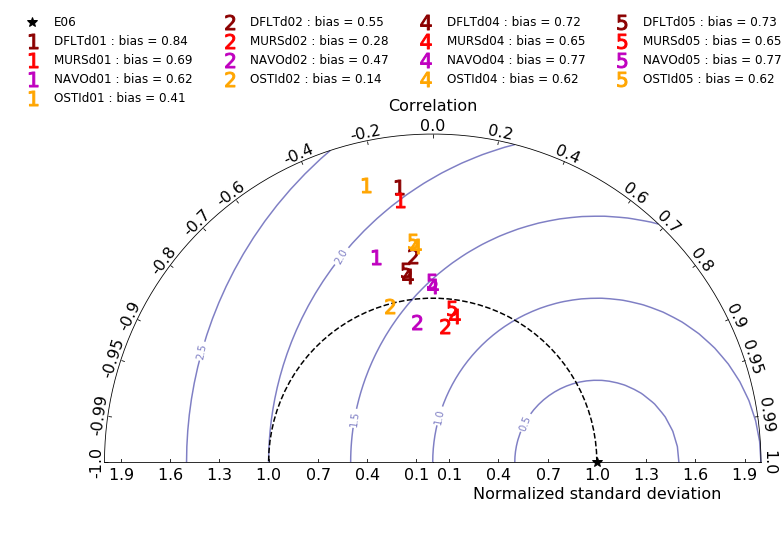

In [99]:
case_selection = None
cases_of_interest = cases[:].copy()
ncases = len(cases_of_interest)

doms_of_interest = [1,2,4,5]
#doms_of_interest = [1,2,3,4,5]


TD_start = '2020-04-06 02:00'
TD_end = '2020-04-06 06:00'
#for dd,lid in enumerate(nyserda_obs.lidar.data):
for dd,lid in enumerate(['E06']):
    for TD_var in ['wspd']:

        
        fig_tay = plt.figure(figsize=(12,9))  
        if TD_var == 'wspd':
            srange=[0.0,2.0]
            stdevticks=np.arange(0.1,5.6,0.3)
            extend_TD = True

        dia = TaylorDiagram(1.0, fig=fig_tay, 
                            extend=extend_TD,
                            label=lid,
                            normalize=True,
                            srange=srange,
                            stdevticks=stdevticks,
                            labelsize=16,
                            extend_length=np.pi*1.0)
        for dom in doms_of_interest:
            dom_str = 'd0{}'.format(dom)
            cases_of_interest_dom = cases_of_interest.copy()
            for cc,case in enumerate(cases_of_interest_dom):
                cases_of_interest_dom[cc] += '_{}'.format(dom_str)

            TD_stats_dict = TaylorDiagramData(obs_ds=lidar_ds_full.sel(station=lid,case='obs',datetime=slice(TD_start,TD_end)),
                                              sim_ds=lidar_ds_full.sel(station=lid,case=cases_of_interest_dom,datetime=slice(TD_start,TD_end)),
                                              average_dim='level',
                                              members_dim='case',
                                              TD_variables=['wspd'])

            ref_std_levels = TD_stats_dict[TD_var]['ref_std']
            sim_std_levels = TD_stats_dict[TD_var]['sim_std']
            sim_cor_levels = TD_stats_dict[TD_var]['sim_cor']
            sim_bia_levels = TD_stats_dict[TD_var]['sim_bias']
            rms_levels = TD_stats_dict[TD_var]['sim_rmse']
            levels = TD_stats_dict[TD_var]['levels']


            td_stats = {}
            for cc,case in enumerate(cases_of_interest):
            #for cc,case in enumerate(cases):
                td_stats[case] = pd.DataFrame(index=levels, columns=['std_norm','R2'], dtype=float) 

                markers = [(i,j,0) for i in range(2,len(levels)+2) for j in range(1, 3)]

                for vv,lvl in enumerate(levels):
                    td_stats[case].loc[lvl,'std_norm'] = sim_std_levels[cc,vv]/ref_std_levels[cc,vv]
                    td_stats[case].loc[lvl,'R2'] = sim_cor_levels[cc,vv]

                    dia.set_ref(ref_std_levels[cc,vv])
                    if cc == 0:
                        label_str = '{}'.format(lvl)
                    else:
                        label_str = None
                    dia.add_sample(sim_std_levels[cc,vv], sim_cor_levels[cc,vv],
                                   #marker=case_dict[case]['marker'], 
                                   marker=dom_dict[dom]['marker'], 
                                   ms=8, ls='',
                                   mfc=case_dict[case]['color'], 
                                   mec=case_dict[case]['color'], # Colors
                                   #label=case_dict[case]['d03']['name'],
                                   zorder=cc,alpha=0.0)
                #plt.text(0.01,0.01+0.04*cc,case,color=case_dict[case]['d03']['color'],ha='left',va='bottom',size=16)
                td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
                td_mean = td_stats[case].mean(axis=0)
                dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                       norm=False, # don't normalize this point
                       #marker=case_dict[case]['marker'], 
                       marker=dom_dict[dom]['marker'], 
                       ms=15, ls='',
                       mfc=case_dict[case]['color'], mec=case_dict[case]['color'], # Colors
                       label=case_dict[case]['case_name'] + 'd0{0} : bias = {1:3.2f}'.format(dom,np.mean(sim_bia_levels[cc,:])),
                       zorder=cc+3,alpha=1.0)
        contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    if extend_TD:
        leg_loc = (0.02,0.8)
        leg_ncol = 4
    else:
        if case_selection == 'SST':
            leg_loc = (0.68,0.71)
        elif case_selection == 'SFC':
            leg_loc = (0.68,0.76)
        elif case_selection == 'LANDUSE':
            leg_loc = (0.68,0.81)
        else:
            leg_loc = (0.64,0.75)


        leg_ncol = 1
    fig_tay.legend(frameon=False,loc=leg_loc,fontsize=12,ncol=leg_ncol)
    #save_str = '{}/img/TD_FINO{}'.format(wrf_dir,fino)
    #if save_figs: plt.savefig('{}.png'.format(save_str))
    #plt.text(0.03,0.03,plt_str,size=20)
    plt.show()
        

In [100]:
def ensemble_statistics(ds,
                        variables=None,
                        observation_key='obs',
                        members_dim=None,
                        members=None,
                        ):

    if members_dim is None:
        raise ValueError ('Must specify dimension that defines the members (members_dim)')
    else:
        if members is None:
            members = list(ds[members_dim].data)
            members.remove(observation_key)
        
    if variables is None:
        variables = list(ds.variables)
        for coord in list(ds.coords):
            variables.remove(coord)

    new_ds = ds.copy()
    for varn in variables:
        data = ds[varn].sel({members_dim:members})
        ens_mean = data.mean(dim=members_dim)
        ens_mean_str = 'ens_mean_{}'.format(varn)
        ens_mean.name = ens_mean_str
        new_ds[ens_mean_str] = ens_mean
        
        ens_spread = (((data - ens_mean)**2).mean(dim=members_dim))**0.5
        ens_spread_str = 'ens_spread_{}'.format(varn)
        ens_spread.name = ens_spread_str
        new_ds[ens_spread_str] = ens_spread
        
        ens_error = ((ds[varn].sel({members_dim:observation_key}) - ens_mean)**2)**0.5
        ens_error_str = 'ens_error_{}'.format(varn)
        ens_error.name = ens_error_str
        new_ds[ens_error_str] = ens_error
        
    return(new_ds)

In [101]:
cases_of_interest = lidar_ds_full.case.data

ens_ds = lidar_ds_full.sel(case=cases_of_interest).copy()
delT = ens_ds.t2 - ens_ds.tsk
delT.name = 'delT'
ens_ds['delT'] = delT

max_wspd = ens_ds.wspd.max(dim='level')
max_wspd.name = 'max_wspd'
ens_ds['max_wspd'] = max_wspd

hub_wspd = ens_ds.wspd.sel(level=118)
hub_wspd.name = 'hub_wspd'
ens_ds['hub_wspd'] = hub_wspd

low_shear = (ens_ds.wspd.sel(level=98) - ens_ds.wspd.sel(level=18))/80.0
low_shear.name = 'low_shear'
ens_ds['low_shear'] = low_shear
print(ens_ds)

<xarray.Dataset>
Dimensions:    (case: 21, datetime: 51, level: 20, station: 4)
Coordinates:
  * case       (case) object 'MERRA2_DFLT_NOSK_CHRN_MDIS_d01' ... 'obs'
  * station    (station) object 'ATS' 'DMV' 'E05' 'E06'
  * datetime   (datetime) datetime64[ns] 2020-04-06T01:00:00 ... 2020-04-06T06:00:00
  * level      (level) int64 10 18 38 40 58 60 78 ... 158 160 178 180 198 200
    Tlevels    int64 ...
Data variables:
    wspd       (case, datetime, level, station) float64 7.435 5.282 ... nan nan
    wdir       (case, datetime, level, station) float64 ...
    w          (case, datetime, level, station) float64 ...
    t2         (case, datetime, station) float64 ...
    tsk        (case, datetime, station) float64 ...
    delT       (case, datetime, station) float64 0.6973 0.3671 ... 0.7 0.82
    max_wspd   (case, datetime, station) float64 14.07 10.74 ... 15.27 15.77
    hub_wspd   (case, datetime, station) float64 12.72 9.468 ... 14.7 14.06
    low_shear  (case, datetime, station)

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nputils.py:215: RuntimeWarning: All-NaN slice encountered
  result = getattr(npmodule, name)(values, axis=axis, **kwargs)


In [102]:
# Not sure if there's a better way than looping... but loop to find LLJ height:
stations_of_interest = ['E06']
llj_height = np.zeros(np.shape(ens_ds.t2.sel(station=stations_of_interest)))
for tt,time in enumerate(ens_ds.datetime):
    wind_profile = ens_ds.sel(datetime=time).wspd
    for cc,case in enumerate(ens_ds.case.data):
        for ll,lid in enumerate(stations_of_interest):
            wind_profile = ens_ds.sel(datetime=time,case=case,station=lid).wspd
            height_profile = ens_ds.sel(datetime=time,case=case,station=lid).level
            #print(wind_profile)
            #print()
            #print(height_profile)
            if case == 'obs':
                if np.isnan(wind_profile.max().data):
                    llj_height[cc,tt,ll] = np.nan
                else:
                    llj_height[cc,tt,ll] = ens_ds.level[np.where(wind_profile==np.nanmax(wind_profile))].data[0]                
            else:
                if np.isnan(wind_profile.max().data):
                    llj_height[cc,tt,ll] = np.nan
                else:
                    llj_height[cc,tt,ll] = height_profile[np.where(wind_profile==wind_profile.max())].data[0]

llj_height_da = xr.DataArray(
                            data=llj_height,
                            dims=['case', 'datetime', 'station'],
                            coords=dict(
                                case=ens_ds.case.data,
                                station=ens_ds.station.sel(station=stations_of_interest).data,
                                datetime=ens_ds.datetime.data,
                            ),
                        )
ens_ds['llj_height'] = llj_height_da

In [103]:
cases_of_interest = cases.copy()
ens_dict = {}
for dom in doms_of_interest:
    dom_str = 'd0{}'.format(dom)
    cases_of_interest_dom = cases_of_interest[:].copy()
    for cc,case in enumerate(cases_of_interest_dom):
        cases_of_interest_dom[cc] += '_{}'.format(dom_str)

    ens_dict[dom_str] = ensemble_statistics(ens_ds.sel(case=cases_of_interest_dom + ['obs']),members_dim='case')

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of emp

In [71]:
class AnyObjectHandler(HandlerBase):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        l1 = plt.Line2D([x0,y0+width], [0.7*height,0.7*height],
                           color=orig_handle[0])
        l2 = plt.Line2D([x0,y0+width], [0.3*height,0.3*height], 
                           color=orig_handle[1])
        return [l1, l2]


/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


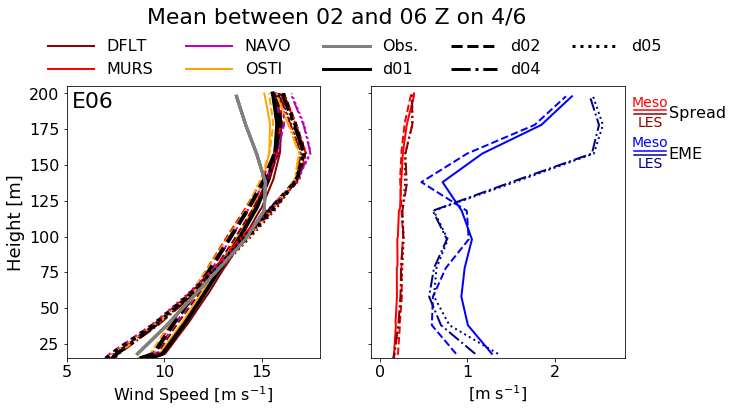

In [104]:
# Pick the time period of interest and average statistics over this period?
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime('2020-04-06 02:00:00')
plt_end = pd.to_datetime(case_end)

fig,ax = plt.subplots(ncols=2,figsize=(10,5),sharey=True)

varn = 'wspd'

#for dd,dom in enumerate(doms_of_interest):
for dd,dom in enumerate([1,2,4,5]):
    
    mean_ls = dom_dict[dom]['ls']
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=slice(plt_start,plt_end)).mean(dim='datetime')

    #cases_of_interest_dom = cases_of_interest[0::4].copy()
    cases_of_interest_dom = cases_of_interest.copy()
    for cc,case in enumerate(cases_of_interest_dom):
        cases_of_interest_dom[cc] += '_{}'.format(dom_str)


    for cc,case in enumerate(cases_of_interest_dom):
        case_str = case.replace('_{}'.format(dom_str),'')

        if (dd == 0):
            plt_lbl = case_dict[case_str]['case_name']
        else:
            plt_lbl = None
        data_toi.sel(case=case,station=lid)[varn].plot(y='level',ax=ax[0],c=case_dict[case_str]['color'],ls=mean_ls,lw=2.0,label=plt_lbl)

    data_toi['ens_mean_{}'.format(varn)].sel(station=lid).plot(y='level',c='k',lw=4.0,ax=ax[0],ls=mean_ls,alpha=1.0)
    data_toi.sel(case='obs')[varn].sel(station=lid).dropna(how='all',dim='level').plot(y='level',ax=ax[0],c='grey',ls=ls,lw=3.0)

    if dd == 0:
        err_str  = 'EME'
        sprd_str = 'Spread'
    else:
        err_str = None
        sprd_str = None

    if dom >= 3:
        spr_c = 'darkred'
        err_c = 'darkblue'
    else:
        spr_c = 'r'
        err_c = 'b'
        
    data_toi['ens_error_{}'.format(varn)].sel(station=lid).dropna(how='all',dim='level').plot(y='level',c=err_c,ax=ax[1],label=err_str,ls=mean_ls,lw=2.0)
    data_toi['ens_spread_{}'.format(varn)].sel(station=lid).plot(y='level',c=spr_c,ax=ax[1],label=sprd_str,ls=mean_ls,lw=2.0)
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_ylabel('')
        ax[axi].set_xlabel('')
        ax[axi].set_title('')

    var_min = ens_ds[varn].min()
    var_max = ens_ds[varn].max()
    var_range = var_max - var_min
    #ax[0].set_xlim(var_min - var_range*0.1,var_max + var_range*0.1)
    var_min,var_max = 5,18
    ax[0].set_xlim(var_min,var_max)
    if varn == 'delT':
        var_str = '∆T'
    else:
        var_str = varn.upper()

    if dd == 0:
        ax[0].plot([-10,-11],[1,1],c='grey',ls=ls,label='Obs.',lw=3.0)
    ax[0].plot([-10,-11],[1,1],c='k',ls=mean_ls,label=dom_str,lw=3.0)

    ax[0].set_ylabel('Height [m]',size=18)
    ax[1].set_xlim(-0.1,2.8)

ax[0].text(0.02,0.98,lid,size=22,va='top',transform=ax[0].transAxes)
ax[0].set_xlabel('Wind Speed [m s$^{-1}$]',size=16)
ax[1].set_xlabel('[m s$^{-1}$]',size=16)
ax[0].set_ylim(15,205)

ax[0].legend(loc=(-0.1,1.01),frameon=False,ncol=5,fontsize=16,handlelength=2.9)


# Complex legend...
leg_x = 1.01
leg_y = 0.7
ax[1].legend([("r","darkred"), ("b","darkblue")], ['Spread', 'EME'],
               handler_map={tuple: AnyObjectHandler()},ncol=1,fontsize=16,
               frameon=False,loc=(leg_x,leg_y),handletextpad=0.2,labelspacing=1.6)
ax[1].text(leg_x + 0.09,leg_y + 0.215,'Meso',c='r',ha='center',va='bottom',fontsize=14,
             transform = ax[1].transAxes)
ax[1].text(leg_x + 0.09,leg_y + 0.19,'LES',c='darkred',ha='center',va='top',fontsize=14,
             transform = ax[1].transAxes)

ax[1].text(leg_x + 0.09,leg_y + 0.065,'Meso',c='b',ha='center',va='bottom',fontsize=14,
             transform = ax[1].transAxes)
ax[1].text(leg_x + 0.09,leg_y + 0.04,'LES',c='darkblue',ha='center',va='top',fontsize=14,
             transform = ax[1].transAxes)

#ax[1].legend(frameon=False,loc=(0.55,0.55),fontsize=16,ncol=1)
plt.suptitle('Mean between {0:02d} and {1:02d} Z on {2}/{3}'.format(plt_start.hour,plt_end.hour,plt_start.month,plt_start.day),
             y=1.1,size=22)
plt.show()

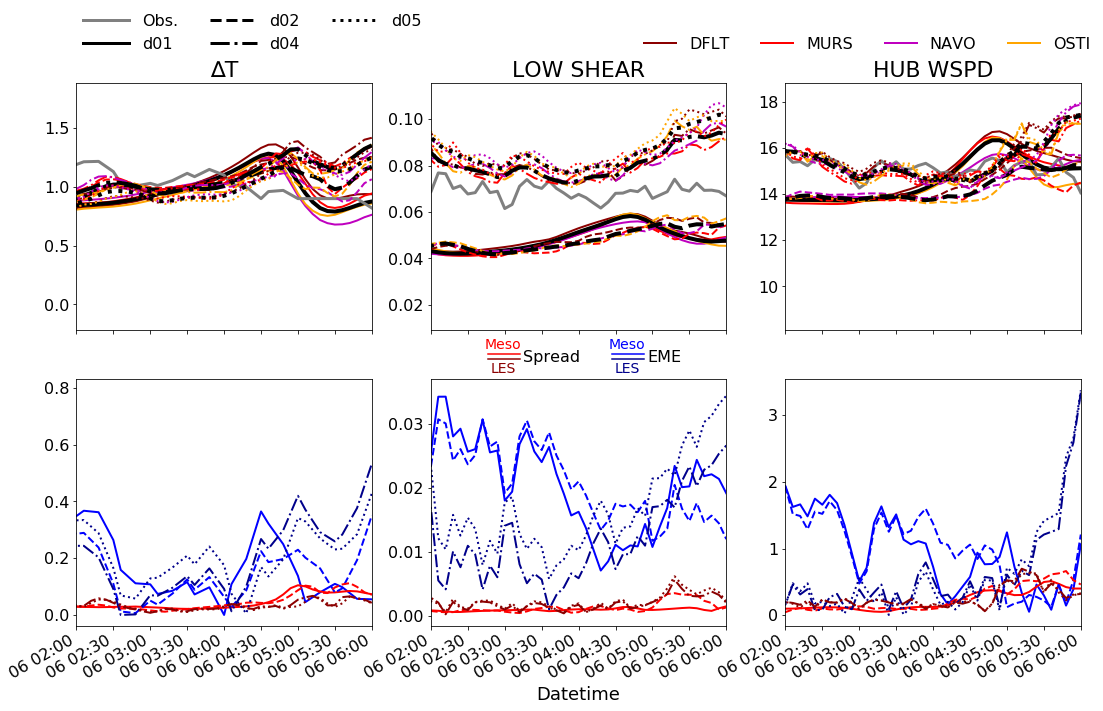

In [113]:
#variables = ['t2','sst','delT','low_shear','max_wspd','hub_wspd','llj_height']

variables = ['delT','low_shear','hub_wspd']

#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime('2020-04-06 02:00:00')
plt_end = pd.to_datetime(case_end)

fig,ax = plt.subplots(nrows=2,ncols=len(variables),figsize=(6*len(variables),10),sharex=True)

lid == 'E06'

var_min_dict = {}
var_max_dict = {}
for vv,varn in enumerate(variables):
    var_min_dict[varn] = 999
    var_max_dict[varn] = -999
    
#for dd,dom in enumerate(doms_of_interest):
for dd,dom in enumerate([1,2,4,5]):
    mean_ls = dom_dict[dom]['ls']
    ls = '-'
        
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]

    cases_of_interest_dom = cases_of_interest.copy()
    for cc,case in enumerate(cases_of_interest_dom):
        cases_of_interest_dom[cc] += '_{}'.format(dom_str)
        
    for vv,varn in enumerate(variables):
        for cc,case in enumerate(cases_of_interest_dom):
            case_str = case.replace('_{}'.format(dom_str),'')
            if (dd == 0) and (vv == 2):
                plt_lbl = case_dict[case_str]['case_name']
            else:
                plt_lbl = None
            ens_dom_ds.sel(case=case,station=lid)[varn].plot(ax=ax[0,vv],c=case_dict[case_str]['color'],ls=mean_ls,lw=2.0,label=plt_lbl)

        ens_dom_ds['ens_mean_{}'.format(varn)].sel(station=lid).plot(c='k',lw=4.0,ax=ax[0,vv],ls=mean_ls,alpha=1.0)
        if dd == 0:
            ens_dom_ds.sel(case='obs')[varn].sel(station=lid).dropna(how='all',dim='datetime').plot(ax=ax[0,vv],c='grey',ls='-',lw=3.0)
        
        if (dd == 10):
            err_str  = 'EME'
            sprd_str = 'Spread'
        else:
            err_str,sprd_str = None,None
            
        if dom >= 3:
            spr_c = 'darkred'
            err_c = 'darkblue'
        else:
            spr_c = 'r'
            err_c = 'b'

        ens_dom_ds['ens_error_{}'.format(varn)].sel(station=lid).dropna(how='all',dim='datetime').plot(c=err_c,ax=ax[1,vv],label=err_str,ls=mean_ls,lw=2.0)
        ens_dom_ds['ens_spread_{}'.format(varn)].sel(station=lid).plot(c=spr_c,ax=ax[1,vv],label=sprd_str,ls=mean_ls,lw=2.0)
        for axi in range(0,2):
            ax[axi,vv].tick_params(labelsize=16)
            ax[axi,vv].set_ylabel('')
            ax[axi,vv].set_xlabel('')

        var_min = ens_dom_ds[varn].min()
        var_max = ens_dom_ds[varn].max()
        if var_min < var_min_dict[varn]: var_min_dict[varn] = var_min
        if var_max > var_max_dict[varn]: var_max_dict[varn] = var_max
        
        if varn == 'delT':
            var_str = '∆T'
        else:
            var_str = varn.upper().replace('_',' ')
        ax[0,vv].set_title(var_str,size=22)
        ax[1,vv].set_title('')        

        if vv == 0:
            if dd == 0:
                ax[0,vv].plot([plt_start,plt_end],[-1,-1],c='grey',ls=ls,label='Obs.',lw=3.0)
            #ax[0,vv].plot([plt_start,plt_end],[-1,-1],c='k',ls=mean_ls,label=str(dom_str),lw=2.0)
            ax[0,vv].plot([plt_start,plt_end],[-1,-1],c='k',ls=mean_ls,lw=3.0,label=str(dom_str))#+' Ens. Mean')

for vv,varn in enumerate(variables):
    var_range = var_max_dict[varn] - var_min_dict[varn]
    ax[0,vv].set_ylim(var_min_dict[varn] - var_range*0.1,var_max_dict[varn] + var_range*0.1)
ax[0,0].set_xlim(plt_start,plt_end)
ax[1,1].set_xlabel('Datetime',size=18)

ax[0,0].legend(loc=(0.0,1.1),frameon=False,ncol=3,fontsize=16,handlelength=2.9)


# Complex legend...
leg_x = 0.17
ax[1,1].legend([("r","darkred"), ("b","darkblue")], ['Spread', 'EME'],
               handler_map={tuple: AnyObjectHandler()},ncol=2,fontsize=16,
               frameon=False,loc=(leg_x,1.03),handletextpad=0.2)
ax[1,1].text(leg_x + 0.075,1.11,'Meso',c='r',ha='center',va='bottom',fontsize=14,
             transform = ax[1,1].transAxes)
ax[1,1].text(leg_x + 0.075,1.07,'LES',c='darkred',ha='center',va='top',fontsize=14,
             transform = ax[1,1].transAxes)

ax[1,1].text(leg_x + 0.495,1.11,'Meso',c='b',ha='center',va='bottom',fontsize=14,
             transform = ax[1,1].transAxes)
ax[1,1].text(leg_x + 0.495,1.07,'LES',c='darkblue',ha='center',va='top',fontsize=14,
             transform = ax[1,1].transAxes)


ax[0,2].legend(frameon=False,loc=(-0.5,1.1),ncol=4,fontsize=16)
plt.show()


# Model-to-Model Comparison:

### Comparing only levels in which we have obs:

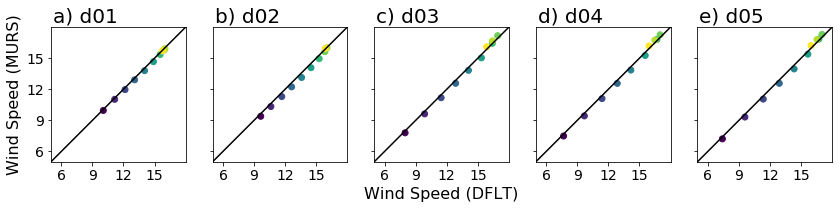

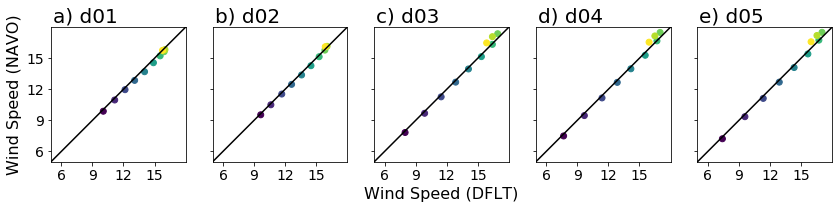

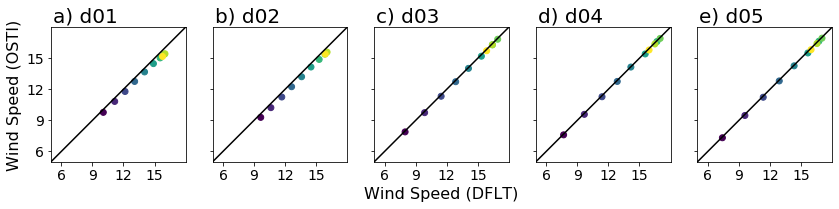

In [106]:
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime('2020-04-06 02:00:00')
plt_end = pd.to_datetime(case_end)

for cc,case in enumerate(cases[1:]):
    fig,ax = plt.subplots(ncols=5,figsize=(14,8),sharey=True)
    for dd,dom in enumerate([1,2,3,4,5]):
        dom_str = 'd0{}'.format(dom)
        chrn = lidar_ds_full.sel(case='{}_{}'.format(cases[0],dom_str),station='E06').wspd
        chrn = chrn.sel(datetime=slice(plt_start,plt_end)).mean(dim='datetime').squeeze().sel(level=nyserda_obs.Ulevels)
        shal = lidar_ds_full.sel(case='{}_{}'.format(case,dom_str),station='E06').wspd
        shal = shal.sel(datetime=slice(plt_start,plt_end)).mean(dim='datetime').squeeze().sel(level=nyserda_obs.Ulevels)
        avg_z = nyserda_obs.Ulevels
        ax[dd].set_aspect('equal')
        ax[dd].scatter(chrn.data,shal.data,c=avg_z.data,cmap=plt.cm.viridis)
        #cbar = plt.colorbar()
        #cbar.ax.tick_params(labelsize=14)

        ax[dd].plot([0,20],[0,20],c='k')
        ax[dd].set_ylim(5,18)
        ax[dd].set_xlim(5,18)
        if dd == 0:
            ax[dd].set_ylabel('Wind Speed ({})'.format(case_dict[case]['case_name']),size=16)
        if dd == 2:
            ax[dd].set_xlabel('Wind Speed ({})'.format(cases[0].split('_')[1]),size=16)
        ax[dd].tick_params(labelsize=14)
        ax[dd].set_yticks(np.arange(6,17,3))
        ax[dd].set_xticks(np.arange(6,17,3))
        ax[dd].text(0.015,1.01,'{}) {}'.format(ascii_lowercase[dd],dom_str),size=20,transform=ax[dd].transAxes,ha='left',va='bottom')


    plt.show()

### Comparing model levels up to 200 m:

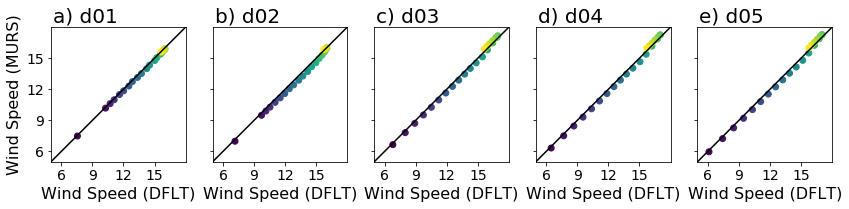

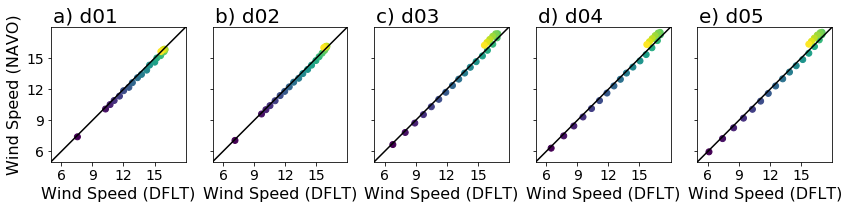

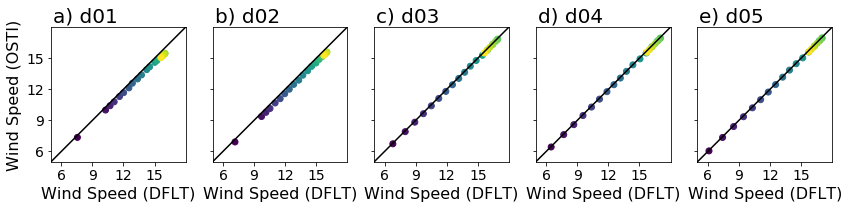

In [107]:
#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime('2020-04-06 02:00:00')
plt_end = pd.to_datetime(case_end)

for cc,case in enumerate(cases[1:]):
    fig,ax = plt.subplots(ncols=5,figsize=(14,8),sharey=True)
    for dd,dom in enumerate([1,2,3,4,5]):
        dom_str = 'd0{}'.format(dom)
        chrn = wrf_data[cases_of_interest[0]][dom_str].wspd.sel(station='E06',datetime=slice(plt_start,plt_end)).mean(dim='datetime').squeeze().sel(nz=slice(0,22))
        avg_z = wrf_data[cases_of_interest[0]][dom_str].sel(station='E06',datetime=slice(plt_start,plt_end)).ph.mean(dim='datetime').squeeze().sel(nz=slice(0,22))
        shal = wrf_data[case][dom_str].wspd.sel(station='E06',datetime=slice(plt_start,plt_end)).mean(dim='datetime').squeeze().sel(nz=slice(0,22))

        ax[dd].set_aspect('equal')
        ax[dd].scatter(chrn.data,shal.data,c=avg_z.data,cmap=plt.cm.viridis)
        #cbar = plt.colorbar()
        #cbar.ax.tick_params(labelsize=14)

        ax[dd].plot([0,20],[0,20],c='k')
        ax[dd].set_ylim(5,18)
        ax[dd].set_xlim(5,18)
        if dd == 0:
            ax[dd].set_ylabel('Wind Speed ({})'.format(case_dict[case]['case_name']),size=16)
        ax[dd].set_xlabel('Wind Speed ({})'.format(cases[0].split('_')[1]),size=16)
        ax[dd].tick_params(labelsize=14)
        ax[dd].set_yticks(np.arange(6,17,3))
        ax[dd].set_xticks(np.arange(6,17,3))
        ax[dd].text(0.015,1.01,'{}) {}'.format(ascii_lowercase[dd],dom_str),size=20,transform=ax[dd].transAxes,ha='left',va='bottom')


    plt.show()

### Quantile / Quantile plot:

In [34]:
from scipy.stats import norm

def calc_probabilities(sample):
    sample = sample
    # calculate parameters
    sample_mean = np.mean(sample)
    sample_std = np.std(sample)
    # define the distribution
    dist = norm(sample_mean, sample_std)
    # sample probabilities for a range of outcomes
    values = [value for value in np.arange(np.min(sample),np.max(sample),0.1)]
    probabilities = [dist.pdf(value) for value in values]
    return(values,probabilities)

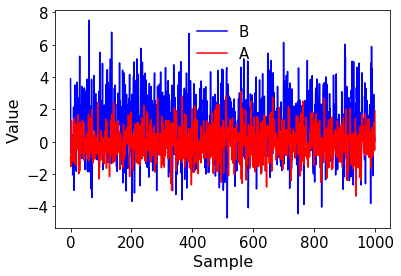

In [35]:
sample_len = 1001
test_a = np.random.normal(size=sample_len)
test_b = np.random.normal(size=sample_len)*2.0+1

plt.plot(np.arange(0,sample_len),test_b,c='b',label='B')
plt.plot(np.arange(0,sample_len),test_a,c='r',label='A')
plt.legend(frameon=False,fontsize=15)
plt.tick_params(labelsize=15)
plt.ylabel('Value',size=16)
plt.xlabel('Sample',size=16)
plt.show()

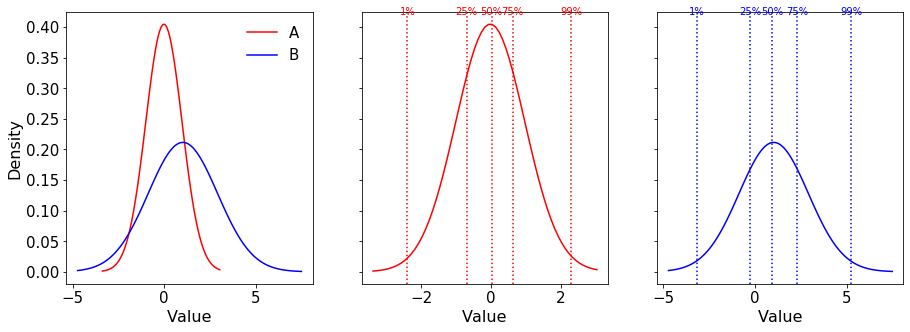

In [36]:
fig,ax = plt.subplots(ncols=3,figsize=(15,5),sharey=True)
val_a,pdf_a = calc_probabilities(test_a)
val_b,pdf_b = calc_probabilities(test_b)
ax[0].plot(val_a,pdf_a,c='r',label='A')
ax[0].plot(val_b,pdf_b,c='b',label='B')

ax[1].plot(val_a,pdf_a,c='r',label='A')
ax[2].plot(val_b,pdf_b,c='b',label='B')

percentiles = [1.0,25.0,50.0,75.0,99.0]
pct_dict = {'A':[],
            'B':[]}

for pct in [1.0,25.0,50.0,75.0,99.0]:
    pct_a = np.percentile(test_a,pct)
    pct_b = np.percentile(test_b,pct)
    pct_dict['A'] += [pct_a]
    pct_dict['B'] += [pct_b]
    ax[1].axvline(pct_a,ls=':',c='r')
    ax[1].text(pct_a,0.42,'{}%'.format(int(pct)),c='r',ha='center')
    ax[2].axvline(pct_b,ls=':',c='b')
    ax[2].text(pct_b,0.42,'{}%'.format(int(pct)),c='b',ha='center')
ax[0].legend(frameon=False,fontsize=15)
ax[0].set_ylabel('Density',size=16)
for axi in range(0,3):
    ax[axi].tick_params(labelsize=15)
    ax[axi].set_xlabel('Value',size=16)
plt.show()

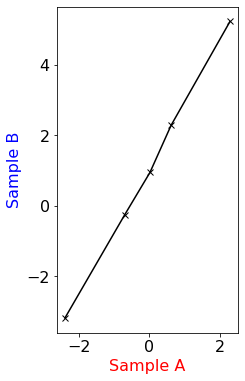

In [37]:
fig,ax = plt.subplots(figsize=(6,6))
ax.set_aspect('equal')
plt.plot(pct_dict['A'],pct_dict['B'],marker='x',c='k')
plt.xlabel('Sample A',c='r',size=16)
plt.ylabel('Sample B',c='b',size=16)
ax.tick_params(labelsize=16)

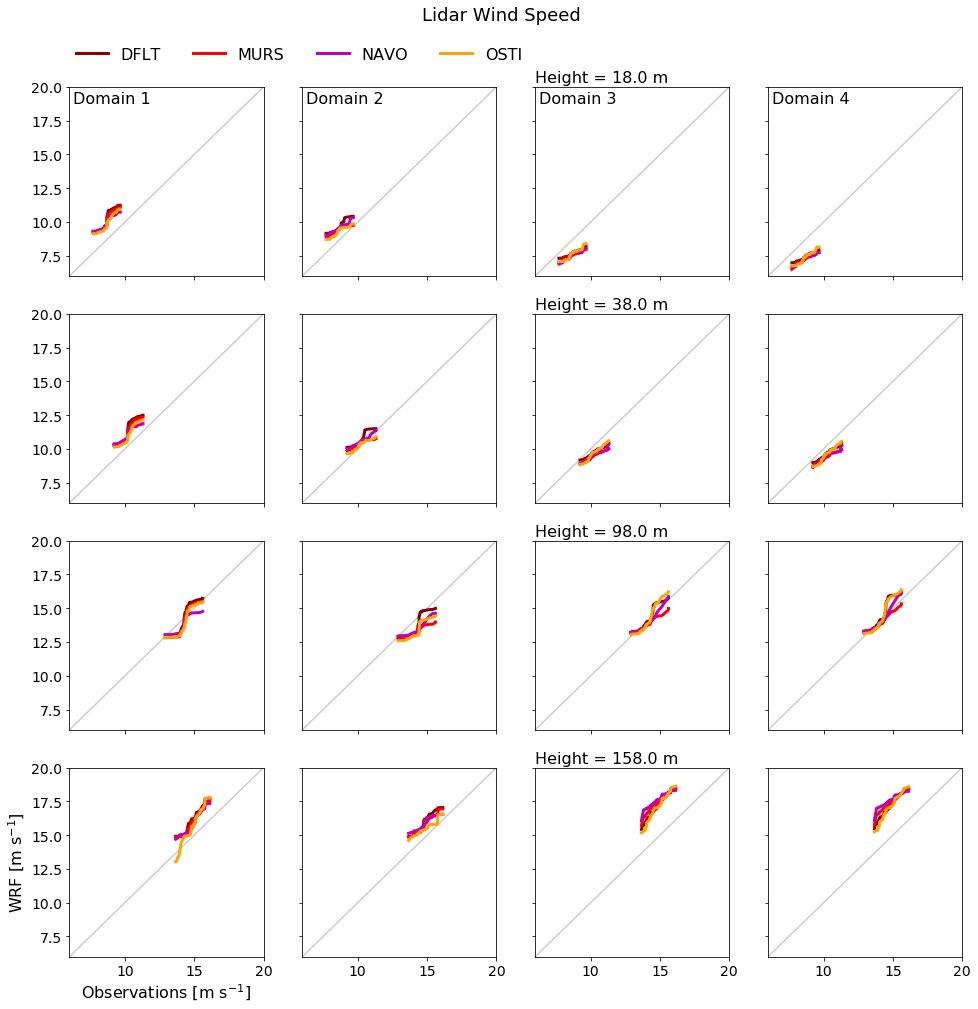

In [108]:
# Get data where we have obs:
lidar_wspd_ds = lidar_ds_full.wspd.sel(station='E06')
lidar_wspd_ds = lidar_wspd_ds.where(~np.isnan(lidar_wspd_ds.sel(case='obs')))

show_test_plot = False

lvl_of_interest = [18,38,98,158]
pct_range = np.arange(1,100)

#plt_start = pd.to_datetime(case_start)
plt_start = pd.to_datetime('2020-04-06 02:00:00')
plt_end = pd.to_datetime(case_end)


for lvl in lvl_of_interest:
    if show_test_plot:
        for case in lidar_wspd_ds.case:
            case_len = 0
            for stn in lidar_wspd_ds.station:
                lidar_wspd_ds.sel(case=case,station=stn,level=lvl).dropna(how='any',dim='datetime').plot(label=str(stn.data))
                case_len += len(lidar_wspd_ds.sel(case=case,station=stn).dropna(how='any',dim='datetime'))
            plt.legend()
            plt.show()  

fig,ax = plt.subplots(ncols=len(doms_of_interest),nrows=len(lvl_of_interest),figsize=(16,16),sharex=True,sharey=True)

case_str = -1
for ll,lvl in enumerate(lvl_of_interest):    
    pmax = 0.0
    for cc,case in enumerate(cases_of_interest):
        for dd,dom in enumerate(doms_of_interest):
            dom_str = 'd0{}'.format(dom)
            case_str = case + '_' + dom_str
            wspd_case = list(lidar_wspd_ds.sel(case=case_str,level=lvl,datetime=slice(plt_start,plt_end)).dropna(how='any',dim='datetime').data.flatten())
            wspd_obs = list(lidar_wspd_ds.sel(case='obs',level=lvl,datetime=slice(plt_start,plt_end)).dropna(how='any',dim='datetime').data.flatten())

            wspd_case = np.asarray(sorted(wspd_case))
            wspd_obs  = np.asarray(sorted(wspd_obs))

            if wspd_case is not []:
                wspd_case_pct = np.percentile(wspd_case,pct_range)
                wspd_obs_pct = np.percentile(wspd_obs,pct_range)

                if np.max([np.max(wspd_case_pct),np.max(wspd_obs_pct)]) > pmax: pmax = np.max([np.max(wspd_case_pct),np.max(wspd_obs_pct)])
                ax[ll,dd].plot(wspd_obs_pct,wspd_case_pct,
                                   c=case_dict[case]['color'],lw=3.0,
                                   label=case_dict[case]['case_name'])

            if case == cases[0]:
                ax[ll,dd].plot([0,40],[0,40],c='k',alpha=0.2)
                plim = pmax+1
                plim = 20
                ax[ll,dd].set_xlim(6.0,plim)
                ax[ll,dd].set_ylim(6.0,plim)
                ax[ll,dd].tick_params(labelsize=14)
                if ll == 0:
                    ax[ll,dd].text(0.02,0.98,'Domain {}'.format(dd+1),
                                       size=16,va='top',transform=ax[ll,dd].transAxes)
                if dd == 2:
                    ax[ll,dd].text(0.0,1.01,'Height = {0:3.1f} m'.format(lvl),
                                       size=16,va='bottom',transform=ax[ll,dd].transAxes)

ax[0,0].legend(frameon=False,fontsize=16,ncol=6,loc=(0.0,1.1))
ax[-1,0].set_xlabel('Observations [m s$^{-1}$]',size=16)
ax[-1,0].set_ylabel('WRF [m s$^{-1}$]',size=16)
plt.suptitle('Lidar Wind Speed',size=18,y=0.95)
plt.show()

### Mean Quantities over Domain:

In [40]:
def get_mean_quantities(cases,wrfout_file_list,main_directory,variables,levels=None):
    init_means = True
    get_water_depth = True

    mean_vars = {}
    for vv,varn in enumerate(variables):
        mean_vars[varn] = {}
        
    count = 0
    for tt,wrf_time in enumerate(wrfout_file_list):
        for cc,case in enumerate(cases):
            
            case_dir = '{}{}/'.format(main_directory,case)
            wrfout = xr.open_dataset('{}{}'.format(case_dir,wrf_time),decode_times=False).sel(Time=0)

            for vv,varn in enumerate(variables):
                if varn == 'wspd':
                    if levels is None:
                        varoi = (wrfout.U10**2 + wrfout.V10**2)**0.5
                    else:
                        u = wrfout.U.sel(bottom_top=levels)
                        v = wrfout.V.sel(bottom_top=levels)
                        u = 0.5*(u[:,:,1:] + u[:,:,:-1])
                        v = 0.5*(v[:,1:,:] + v[:,:-1,:])
                        u = u.rename({'west_east_stag':'west_east'})
                        v = v.rename({'south_north_stag':'south_north'})
                        varoi = (u**2 + v**2)**0.5
                else:
                    varoi = wrfout[varn]
                    if len(np.shape(varoi)) > 2:
                        if levels is not None:
                            if 'bottom_top' in varoi.dims:
                                varoi = varoi.sel(bottom_top=levels)
                            elif 'bottom_top_stag' in varoi.dims:
                                varoi = varoi.sel(bottom_top_stag=levels)
                        else:
                            raise ValueError('Dimensions are greater than 2... specify levels.')

                if init_means:
                    mean_vars[varn][case] = varoi
                else:
                    mean_vars[varn][case] += varoi
        init_means = False
        count += 1

    mean_da_dict = {}
    for cc,case in enumerate(cases):
        for vv,varn in enumerate(variables):
            mean_vars[varn][case] /= count
            da = mean_vars[varn][case]
            da = da.assign_coords({'case':case}).expand_dims({'case':1})
            da.name = varn

            mean_da_dict[varn] = da

        if cc == 0:
            mean_ds = xr.Dataset(mean_da_dict)
        else:
            mean_ds = xr.merge((mean_ds,xr.Dataset(mean_da_dict)))
        
            
    return(mean_ds)

In [41]:
avg_wrf_dict = {}
avg_time_s = pd.to_datetime('2020-04-06 02:00:00')
avg_time_e = pd.to_datetime('2020-04-06 06:00:00')

doms_of_interest = [2,5]

for cc,case in enumerate(cases):
    for dd,dom in enumerate(doms_of_interest):
        #avg_wrf_dict[dom] = {}
        if dom <= 2:
            wrfout_path = '{}'.format(main_directory)
        else:
            wrfout_path = '{}'.format(main_directory)
        wrfout_f = sorted(glob.glob('{}{}/wrfout_d0{}*'.format(wrfout_path,case,dom)))

        avg_wrfouts = []
        for ff in wrfout_f:
            wrfouttime = pd.to_datetime(' '.join(ff.split('/')[-1].split('_')[-2:]))
            if (wrfouttime >= avg_time_s) and (wrfouttime <= avg_time_e):
                avg_wrfouts.append(ff.split('/')[-1])
                 
    
        if (dom == 5) and cc == 0:
            cases_of_interest_mean = cases_of_interest[1:]
        else:
            cases_of_interest_mean = cases_of_interest
        avg_wrf_dict[dom] = get_mean_quantities(cases_of_interest_mean,avg_wrfouts,wrfout_path,['wspd','ZNT','UST'])


In [46]:
avg_wrf_dict[2]

<xarray.Dataset>
Dimensions:  (case: 4, south_north: 480, west_east: 480)
Coordinates:
  * case     (case) object 'MERRA2_DFLT_NOSK_CHRN_MDIS' ... 'MERRA2_OSTI_NOSK_CHRN_MDIS'
    XLAT     (south_north, west_east) float32 37.334507 37.335278 ... 43.056778
    XLONG    (south_north, west_east) float32 -75.85132 -75.83673 ... -68.74164
    XTIME    float32 2640.0
Dimensions without coordinates: south_north, west_east
Data variables:
    wspd     (case, south_north, west_east) float32 5.778911 ... 10.378152
    ZNT      (case, south_north, west_east) float32 8.0556325e-05 ... 0.0002975608
    UST      (case, south_north, west_east) float32 0.19536601 ... 0.39410445

In [42]:
d02_diff = avg_wrf_dict[2].sel(case=cases_of_interest[1]) - avg_wrf_dict[2].sel(case=cases_of_interest[0])
d05_diff = avg_wrf_dict[5].sel(case=cases_of_interest[1]) - avg_wrf_dict[5].sel(case=cases_of_interest[0])

In [43]:
d02_diff

<xarray.Dataset>
Dimensions:  (south_north: 480, west_east: 480)
Coordinates:
    XLAT     (south_north, west_east) float32 37.334507 37.335278 ... 43.056778
    XLONG    (south_north, west_east) float32 -75.85132 -75.83673 ... -68.74164
    XTIME    float32 2640.0
Dimensions without coordinates: south_north, west_east
Data variables:
    wspd     (south_north, west_east) float32 0.051552773 ... 0.13452911
    ZNT      (south_north, west_east) float32 3.1527306e-06 ... 1.10041e-05
    UST      (south_north, west_east) float32 0.0041956455 ... 0.0074908733

Text(0.5, 1.0, 'd05')

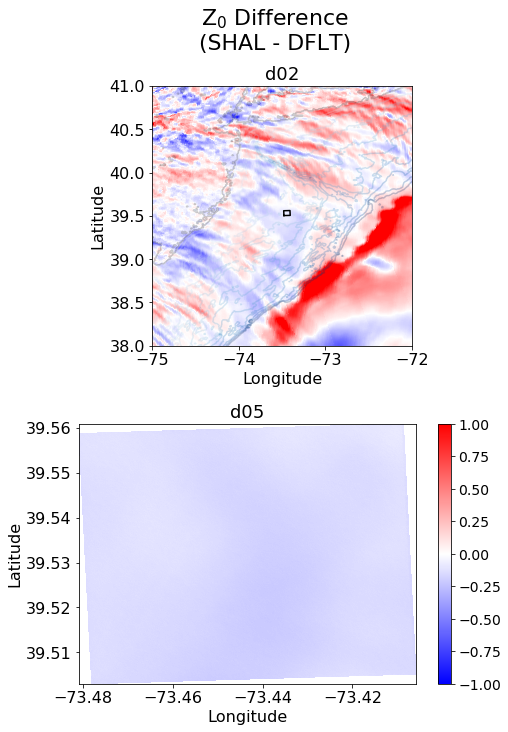

In [47]:
fig,ax = plt.subplots(nrows=2,figsize=(8,11))
plt.subplots_adjust(hspace=0.3)
pval = 1.0
d02_in = xr.open_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/{}/wrfinput_d02'.format(cases_of_interest[0])).squeeze()
d05_in = xr.open_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/{}/wrfinput_d05'.format(cases_of_interest[0])).squeeze()

d02_lat = d02_in.XLAT
d02_lon = d02_in.XLONG
d02_landmask = d02_in.LANDMASK
d02_water_depth = d02_in.WATER_DEPTH

d05_lat = d05_in.XLAT
d05_lon = d05_in.XLONG
d05_landmask = d05_in.LANDMASK

d02_plt = ax[0].pcolormesh(d02_lon,d02_lat,d02_diff.wspd,vmin=-pval,vmax=pval,cmap=plt.cm.bwr)
ax[0].contour(d02_lon,d02_lat,d02_landmask,levels=[0.5],colors='k',alpha=0.25)
ax[0].contour(d02_lon,d02_lat,d02_water_depth,levels=np.arange(0,101,10),cmap=plt.cm.Blues,alpha=0.25)
ax[0].set_xlim(-75,-72)
ax[0].set_ylim(38,41)
d05_plt = ax[1].pcolormesh(d05_lon,d05_lat,d05_diff.wspd,vmin=-pval,vmax=pval,cmap=plt.cm.bwr)

#cbar = plt.colorbar(d02_plt,ax=ax[0])
cbar = plt.colorbar(d05_plt,ax=ax[1])
cbar.ax.tick_params(labelsize=14)

for axi in range(0,2):
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_aspect('equal')
    ax[axi].set_xlabel('Longitude',size=16)
    ax[axi].set_ylabel('Latitude',size=16)
    
d05_outline_x = [d05_lon[0,0],d05_lon[-1,0],d05_lon[-1,-1],d05_lon[0,-1],d05_lon[0,0]]
d05_outline_y = [d05_lat[0,0],d05_lat[-1,0],d05_lat[-1,-1],d05_lat[0,-1],d05_lat[0,0]]

ax[0].plot(d05_outline_x,d05_outline_y,c='k')
plt.suptitle('Z$_0$ Difference\n(SHAL - DFLT)',size=22)#,y=1.02)
ax[0].set_title('d02',size=18)
ax[1].set_title('d05',size=18)

Text(0.5, 1.0, 'd05')

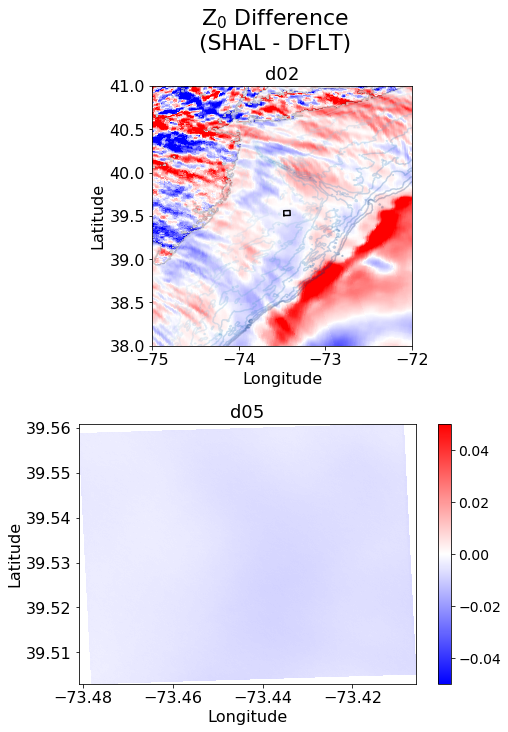

In [48]:
fig,ax = plt.subplots(nrows=2,figsize=(8,11))
plt.subplots_adjust(hspace=0.3)
pval = 0.05
d02_in = xr.open_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/{}/wrfinput_d02'.format(cases_of_interest[1])).squeeze()
d05_in = xr.open_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/{}/wrfinput_d05'.format(cases_of_interest[1])).squeeze()

d02_lat = d02_in.XLAT
d02_lon = d02_in.XLONG
d02_landmask = d02_in.LANDMASK
d02_water_depth = d02_in.WATER_DEPTH

d05_lat = d05_in.XLAT
d05_lon = d05_in.XLONG
d05_landmask = d05_in.LANDMASK

d02_plt = ax[0].pcolormesh(d02_lon,d02_lat,d02_diff.UST,vmin=-pval,vmax=pval,cmap=plt.cm.bwr)
ax[0].contour(d02_lon,d02_lat,d02_landmask,levels=[0.5],colors='k',alpha=0.25)
ax[0].contour(d02_lon,d02_lat,d02_water_depth,levels=np.arange(0,101,10),cmap=plt.cm.Blues,alpha=0.25)
ax[0].set_xlim(-75,-72)
ax[0].set_ylim(38,41)
d05_plt = ax[1].pcolormesh(d05_lon,d05_lat,d05_diff.UST,vmin=-pval,vmax=pval,cmap=plt.cm.bwr)

#cbar = plt.colorbar(d02_plt,ax=ax[0])
cbar = plt.colorbar(d05_plt,ax=ax[1])
cbar.ax.tick_params(labelsize=14)

for axi in range(0,2):
    ax[axi].tick_params(labelsize=16)
    ax[axi].set_aspect('equal')
    ax[axi].set_xlabel('Longitude',size=16)
    ax[axi].set_ylabel('Latitude',size=16)
    
d05_outline_x = [d05_lon[0,0],d05_lon[-1,0],d05_lon[-1,-1],d05_lon[0,-1],d05_lon[0,0]]
d05_outline_y = [d05_lat[0,0],d05_lat[-1,0],d05_lat[-1,-1],d05_lat[0,-1],d05_lat[0,0]]

ax[0].plot(d05_outline_x,d05_outline_y,c='k')
plt.suptitle('Z$_0$ Difference\n(SHAL - DFLT)',size=22)#,y=1.02)
ax[0].set_title('d02',size=18)
ax[1].set_title('d05',size=18)

# Making subset of the data for Raj:

In [6]:
twr_directory = '/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/tower_netCDFs/'

chunked_files = sorted(glob.glob('{}NYSERDA_{}*d05_chunk*'.format(twr_directory,cases[0])))

for ff,chunk in enumerate(chunked_files):
    print(chunk)
    test = xr.open_dataset(chunk)
    tmean = test.mean(dim='station')
    test = test.sel(station=['E06'])
    if ff == 0:
        test_f = test.copy()
        tmean_f = tmean.copy()
    else:
        test_f = xr.merge([test,test_f])
        tmean_f = xr.merge([tmean,tmean_f])
tmean_f = tmean_f.expand_dims({'station':['mean']})

tmean_f.to_netcdf('{}for_raj_d05_mean.nc'.format(twr_directory))
test_f.to_netcdf('{}for_raj_d05_e06.nc'.format(twr_directory))

## Add Will's Data:

In [22]:
will_ds = xr.open_dataset('/glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/LES/MERRA2_DFLT_NOSK_CHRN_MDIS/d05_output.nc').mean(dim='Time')

will_ds['wspd'] = (will_ds.U10**2 + will_ds.V10**2)**0.5
will_ds = will_ds[['wspd','ZNT','UST']]
will_ds = will_ds.assign_coords({'case':cases_of_interest[0]}).expand_dims({'case':1})

avg_wrf_dict[5] = xr.merge((avg_wrf_dict[5],will_ds))

-------
# Old...

# Resample WRF to Obs times / heights:

In [152]:
profile_times = pd.date_range(case_start,case_end,periods=n_profiles)
time_colors = {}
for pp,pt in enumerate(profile_times):
    line_cols = plt.cm.jet(np.linspace(0.10,0.9,n_profiles))[pp]
    darken = 0.2
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    time_colors[pt] = line_cols

data_ds_fname = '{}resampled_data_obs_and_WRF_E06.nc'.format(twr_directory)

if path.exists(data_ds_fname):
    print('Loading in {}'.format(data_ds_fname))
    data_ds = xr.open_dataset(data_ds_fname)
else:
    print('Resampling WRF and packaging into {}'.format(data_ds_fname))
    init_wspd_da = True
    good_wrf_lvls = {}
    #for dd,lid in enumerate(nyserda_obs.lidar.data):
    for dd,lid in enumerate(['E06']):
        good_wrf_lvls[lid] = {}
        
        nyserda_obs_case = nyserda_obs.sel(datetime=slice(case_start,case_end))
        good_levels = []

        for lvl in nyserda_obs.Ulevels.data:
            wspd_obs = nyserda_obs_case.wspd.sel(lidar=lid,Ulevels=lvl,
                                                 datetime=slice(case_start,case_end))
            if len(wspd_obs.dropna(how='any',dim='datetime')) > 1:
                data_ds_0 = wspd_obs.assign_coords({'level':lvl,'case':'obs'}
                                   ).expand_dims({'level':1,'case':1,'lidar':1}
                                   ).drop(['Ulevels']).to_dataset()
                data_ds_0['wrf_level'] = xr.DataArray([[[np.nan]]],dims=['level','case','lidar'])
                if init_wspd_da:
                    data_ds = data_ds_0.copy()
                    init_wspd_da = False
                else:
                    data_ds = data_ds.combine_first(data_ds_0)

                plot_this_level = True
                good_levels.append(lvl)                    
            else:
                plot_this_level = False
        
        
        for cc,case in enumerate(cases_of_interest):
            print(case)
            for dd,dom in enumerate(doms_of_interest):
                dom_str = 'd0{}'.format(dom)
                good_wrf_lvls[lid][case] = []

                wrf_data_res = wrf_data[case][dom_str].resample({'datetime':'10min'}).mean().sel(
                                                        datetime=slice(case_start,case_end))

                wrf_levels = wrf_data_res.ph.mean(dim='datetime').sel(station=lid)

                for lvl in good_levels:
                    wspd_obs = nyserda_obs_case.wspd.sel(lidar=lid,Ulevels=lvl,
                                                         datetime=slice(case_start,case_end))
                    level_dist = abs(wrf_levels - lvl)
                    wrf_lvl_ind = int(np.where(level_dist == np.nanmin(level_dist))[0])
                    if (level_dist[wrf_lvl_ind] <= 10.0):
                        wrf_lvl = float(wrf_levels[wrf_lvl_ind].data)
                        if wrf_lvl not in good_wrf_lvls[lid]:
                            good_wrf_lvls[lid][case].append(wrf_lvl)
                        wspd_wrf = wrf_data_res.wspd.sel(nz=wrf_lvl_ind,station=lid)
                        wspd_wrf[np.where(np.isnan(wspd_obs))] = np.nan
                        wrf_ds = wspd_wrf.rename({'station':'lidar'}
                                        ).assign_coords({'level':lvl,'case':case+'_'+dom_str}
                                        ).expand_dims({'level':1,'case':1,'lidar':1}
                                        ).drop(['k','zsurface']).to_dataset()

                        wrf_ds['wrf_level'] = xr.DataArray([[[wrf_lvl]]],dims=['level','case','lidar'])
                        data_ds = data_ds.combine_first(wrf_ds)

                sst_ds = wrf_data_res.tsk.sel(station=lid).rename({'station':'lidar'}
                                        ).assign_coords({'case':case+'_'+dom_str}
                                        ).expand_dims({'case':1,'lidar':1}
                                        ).drop(['zsurface'])
                sst_ds.name = 'sst'

                t2_ds = wrf_data_res.t2.sel(station=lid).rename({'station':'lidar'}
                                        ).assign_coords({'case':case+'_'+dom_str}
                                        ).expand_dims({'case':1,'lidar':1}
                                        ).drop(['zsurface'])
                t2_ds.name = 't2'
                if cc + dd == 0:
                    obs_sst_ds = nyserda_obs_case.sst.sel(lidar=lid
                                                   ).assign_coords({'case':'obs'}
                                                   ).expand_dims({'case':1,'lidar':1}
                                                   ).to_dataset()
                    obs_t2_da = nyserda_obs_case.T.sel(lidar=lid,Tlevels=2
                                                   ).assign_coords({'case':'obs'}
                                                   ).expand_dims({'case':1,'lidar':1}
                                                   ).drop(['Tlevels'])
                    obs_t2_da.name = 't2'
                    obs_t2_ds = obs_t2_da.to_dataset()
                    sst_ds = obs_sst_ds.combine_first(sst_ds)
                    t2_ds = obs_t2_ds.combine_first(t2_ds)

                data_ds = xr.merge((data_ds,sst_ds,t2_ds))

    data_ds.to_netcdf(data_ds_fname)


Loading in /glade/scratch/hawbecke/WRF/MMC/NYSERDA/SENSITIVITY_SUITE/production/tower_netCDFs/resampled_data_obs_and_WRF_E06.nc


/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


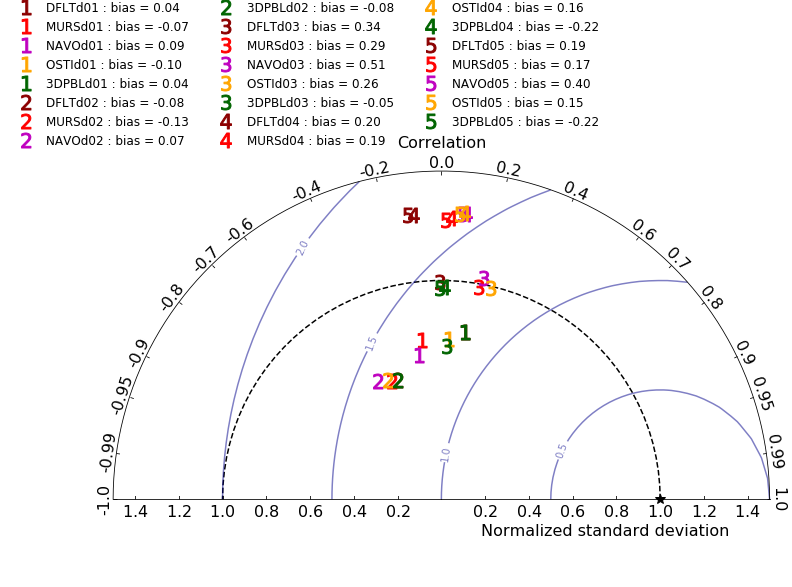

In [44]:
case_selection = None
cases_of_interest = cases[:].copy()
ncases = len(cases_of_interest)

#lidar_ds_full_interp = lidar_ds_full.resample({'datetime':'10min'}).mean().sel()
lidar_ds_full_interp = lidar_ds_full.resample({'datetime':'10min'}).mean().sel(level=nyserda_obs.Ulevels.data,
                                                                              datetime=slice('2020-04-06 01:00','2020-04-06 04:00'))

#for dd,lid in enumerate(nyserda_obs.lidar.data):
for dd,lid in enumerate(['E06']):
    for TD_var in ['wspd']:

        
        fig_tay = plt.figure(figsize=(12,9))  
        if TD_var == 'wspd':
            srange=[0.0,1.5]
            stdevticks=np.arange(0.2,5.6,0.2)
            extend_TD = True

        dia = TaylorDiagram(1.0, fig=fig_tay, 
                            extend=extend_TD,
                            label=lid,
                            normalize=True,
                            srange=srange,
                            stdevticks=stdevticks,
                            labelsize=16,
                            extend_length=np.pi*1.0)
        for dom in doms_of_interest:
            dom_str = 'd0{}'.format(dom)
            cases_of_interest_dom = cases_of_interest.copy()
            for cc,case in enumerate(cases_of_interest_dom):
                cases_of_interest_dom[cc] += '_{}'.format(dom_str)

                
            #print(lidar_ds_full_interp.sel(station=lid,case='obs'))
            #print()
            #print(lidar_ds_full_interp.sel(station=lid,case=cases_of_interest_dom))
            #print()
            TD_stats_dict = TaylorDiagramData(obs_ds=lidar_ds_full_interp.sel(station=lid,case='obs'),
                                              sim_ds=lidar_ds_full_interp.sel(station=lid,case=cases_of_interest_dom),
                                              average_dim='level',
                                              members_dim='case',
                                              TD_variables=['wspd'])

            ref_std_levels = TD_stats_dict[TD_var]['ref_std']
            sim_std_levels = TD_stats_dict[TD_var]['sim_std']
            sim_cor_levels = TD_stats_dict[TD_var]['sim_cor']
            sim_bia_levels = TD_stats_dict[TD_var]['sim_bias']
            rms_levels = TD_stats_dict[TD_var]['sim_rmse']
            levels = TD_stats_dict[TD_var]['levels']


            td_stats = {}
            for cc,case in enumerate(cases_of_interest):
            #for cc,case in enumerate(cases):
                td_stats[case] = pd.DataFrame(index=levels, columns=['std_norm','R2'], dtype=float) 

                markers = [(i,j,0) for i in range(2,len(levels)+2) for j in range(1, 3)]

                for vv,lvl in enumerate(levels):
                    td_stats[case].loc[lvl,'std_norm'] = sim_std_levels[cc,vv]/ref_std_levels[cc,vv]
                    td_stats[case].loc[lvl,'R2'] = sim_cor_levels[cc,vv]

                    dia.set_ref(ref_std_levels[cc,vv])
                    if cc == 0:
                        label_str = '{}'.format(lvl)
                    else:
                        label_str = None
                    dia.add_sample(sim_std_levels[cc,vv], sim_cor_levels[cc,vv],
                                   #marker=case_dict[case]['marker'], 
                                   marker=dom_dict[dom]['marker'], 
                                   ms=8, ls='',
                                   mfc=case_dict[case]['color'], 
                                   mec=case_dict[case]['color'], # Colors
                                   #label=case_dict[case]['d03']['name'],
                                   zorder=cc,alpha=0.0)
                #plt.text(0.01,0.01+0.04*cc,case,color=case_dict[case]['d03']['color'],ha='left',va='bottom',size=16)
                td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
                td_mean = td_stats[case].mean(axis=0)
                dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                       norm=False, # don't normalize this point
                       #marker=case_dict[case]['marker'], 
                       marker=dom_dict[dom]['marker'], 
                       ms=15, ls='',
                       mfc=case_dict[case]['color'], mec=case_dict[case]['color'], # Colors
                       label=case_dict[case]['case_name'] + 'd0{0} : bias = {1:3.2f}'.format(dom,np.mean(sim_bia_levels[cc,:])),
                       zorder=cc+3,alpha=1.0)
        contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    if extend_TD:
        leg_loc = (0.01,0.74)
        leg_ncol = 3
    else:
        if case_selection == 'SST':
            leg_loc = (0.68,0.71)
        elif case_selection == 'SFC':
            leg_loc = (0.68,0.76)
        elif case_selection == 'LANDUSE':
            leg_loc = (0.68,0.81)
        else:
            leg_loc = (0.64,0.75)


        leg_ncol = 1
    fig_tay.legend(frameon=False,loc=leg_loc,fontsize=12,ncol=leg_ncol)
    #save_str = '{}/img/TD_FINO{}'.format(wrf_dir,fino)
    #if save_figs: plt.savefig('{}.png'.format(save_str))
    #plt.text(0.03,0.03,plt_str,size=20)
    plt.show()
        

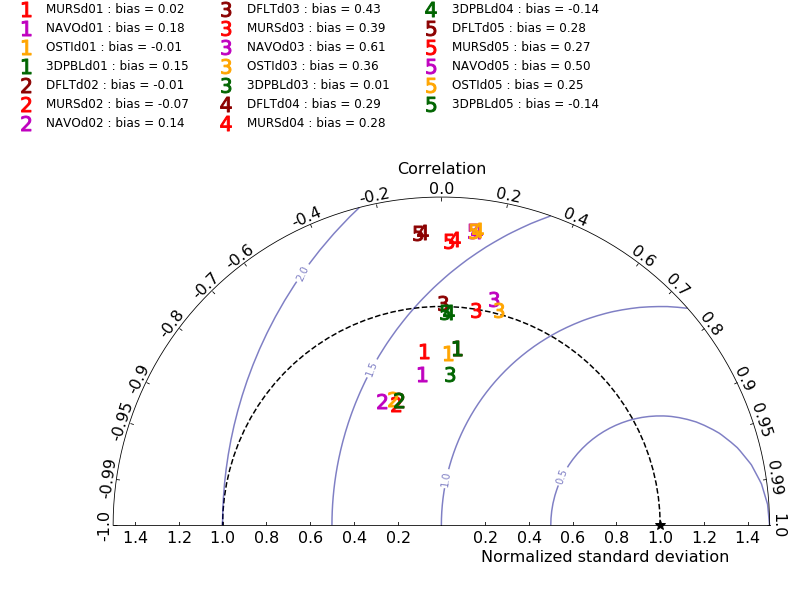

In [161]:
lvl_colors = {}
for ss,lvl in enumerate(data_ds.level.data):
    line_cols = plt.cm.viridis(np.linspace(0.0,1.0,len(levels)))[ss]
    darken = 0.1
    for tt,col in enumerate(line_cols):
        if tt < 3:
            line_cols[tt] = col - darken
            if line_cols[tt] < 0.0: line_cols[tt] = 0.0
    lvl_colors[lvl] = line_cols


case_selection = None
cases_of_interest = cases[:].copy()
ncases = len(cases_of_interest)


#for dd,lid in enumerate(nyserda_obs.lidar.data):
for dd,lid in enumerate(['E06']):
    for TD_var in ['wspd']:

        
        fig_tay = plt.figure(figsize=(12,9))  
        if TD_var == 'wspd':
            srange=[0.0,1.5]
            stdevticks=np.arange(0.2,5.6,0.2)
            extend_TD = True

        dia = TaylorDiagram(1.0, fig=fig_tay, 
                            extend=extend_TD,
                            label=lid,
                            normalize=True,
                            srange=srange,
                            stdevticks=stdevticks,
                            labelsize=16,
                            extend_length=np.pi*1.0)
        for dom in [1,2,3,4,5]:
            dom_str = 'd0{}'.format(dom)
            cases_of_interest_dom = cases_of_interest.copy()
            for cc,case in enumerate(cases_of_interest_dom):
                cases_of_interest_dom[cc] += '_{}'.format(dom_str)

            #print(data_ds.sel(lidar=lid,case='obs'))
            #print()
            #print(data_ds.sel(lidar=lid,case=cases_of_interest_dom))
            #print()
            TD_stats_dict = TaylorDiagramData(obs_ds=data_ds.sel(lidar=lid,case='obs'),
                                              sim_ds=data_ds.sel(lidar=lid,case=cases_of_interest_dom),
                                              average_dim='level',
                                              members_dim='case',
                                              TD_variables=['wspd'])

            ref_std_levels = TD_stats_dict[TD_var]['ref_std']
            sim_std_levels = TD_stats_dict[TD_var]['sim_std']
            sim_cor_levels = TD_stats_dict[TD_var]['sim_cor']
            sim_bia_levels = TD_stats_dict[TD_var]['sim_bias']
            rms_levels = TD_stats_dict[TD_var]['sim_rmse']
            levels = TD_stats_dict[TD_var]['levels']


            td_stats = {}
            for cc,case in enumerate(cases_of_interest):
            #for cc,case in enumerate(cases):
                td_stats[case] = pd.DataFrame(index=levels, columns=['std_norm','R2'], dtype=float) 

                markers = [(i,j,0) for i in range(2,len(levels)+2) for j in range(1, 3)]

                for vv,lvl in enumerate(levels):
                    td_stats[case].loc[lvl,'std_norm'] = sim_std_levels[cc,vv]/ref_std_levels[cc,vv]
                    td_stats[case].loc[lvl,'R2'] = sim_cor_levels[cc,vv]

                    dia.set_ref(ref_std_levels[cc,vv])
                    if cc == 0:
                        label_str = '{}'.format(lvl)
                    else:
                        label_str = None
                    dia.add_sample(sim_std_levels[cc,vv], sim_cor_levels[cc,vv],
                                   #marker=case_dict[case]['marker'], 
                                   marker=dom_dict[dom]['marker'], 
                                   ms=8, ls='',
                                   mfc=case_dict[case]['color'], 
                                   #mec=case_dict[case]['color'], # Colors
                                   #mfc=lvl_colors[lvl], 
                                   mec=lvl_colors[lvl], # Colors
                                   #label=case_dict[case]['d03']['name'],
                                   zorder=cc,alpha=0.0)
                #plt.text(0.01,0.01+0.04*cc,case,color=case_dict[case]['d03']['color'],ha='left',va='bottom',size=16)
                td_stats[case]['angle'] = np.arccos(td_stats[case]['R2'])
                td_mean = td_stats[case].mean(axis=0)
                dia.add_sample(td_mean['std_norm'], np.cos(td_mean['angle']),
                       norm=False, # don't normalize this point
                       #marker=case_dict[case]['marker'], 
                       marker=dom_dict[dom]['marker'], 
                       ms=15, ls='',
                       mfc=case_dict[case]['color'], mec=case_dict[case]['color'], # Colors
                       label=case_dict[case]['case_name'] + 'd0{0} : bias = {1:3.2f}'.format(dom,np.mean(sim_bia_levels[cc,:])),
                       zorder=cc+3,alpha=1.0)
        contours = dia.add_contours(levels=5, colors='darkblue',alpha=0.5)
        dia.ax.clabel(contours, inline=1, fontsize=10, fmt='%.1f')
    if extend_TD:
        leg_loc = (0.01,0.78)
        leg_ncol = 3
    else:
        if case_selection == 'SST':
            leg_loc = (0.68,0.71)
        elif case_selection == 'SFC':
            leg_loc = (0.68,0.76)
        elif case_selection == 'LANDUSE':
            leg_loc = (0.68,0.81)
        else:
            leg_loc = (0.64,0.75)


        leg_ncol = 1
    fig_tay.legend(frameon=False,loc=leg_loc,fontsize=12,ncol=leg_ncol)
    #save_str = '{}/img/TD_FINO{}'.format(wrf_dir,fino)
    #if save_figs: plt.savefig('{}.png'.format(save_str))
    #plt.text(0.03,0.03,plt_str,size=20)
    plt.show()
        

In [303]:
cases_of_interest = data_ds.case.data

ens_ds = data_ds.sel(case=cases_of_interest).copy()
delT = ens_ds.t2 - ens_ds.sst
delT.name = 'delT'
ens_ds['delT'] = delT

max_wspd = ens_ds.wspd.max(dim='level')
max_wspd.name = 'max_wspd'
ens_ds['max_wspd'] = max_wspd

hub_wspd = ens_ds.wspd.sel(level=120)
hub_wspd.name = 'hub_wspd'
ens_ds['hub_wspd'] = hub_wspd

low_shear = (ens_ds.wspd.sel(level=100) - ens_ds.wspd.sel(level=20))/80.0
low_shear.name = 'low_shear'
ens_ds['low_shear'] = low_shear
print(ens_ds)

<xarray.Dataset>
Dimensions:    (case: 26, datetime: 19, level: 10, lidar: 1)
Coordinates:
  * case       (case) object 'MERRA2_DFLT_NOSK_CHRN_MDIS_3dpbl_d01' ... 'obs'
  * level      (level) int64 20 40 60 80 100 120 140 160 180 200
  * lidar      (lidar) object 'E06'
  * datetime   (datetime) datetime64[ns] 2020-04-06T01:00:00 ... 2020-04-06T04:00:00
    lon        float64 ...
    lat        float64 ...
Data variables:
    wspd       (level, case, lidar, datetime) float64 9.852 9.882 ... 12.86
    wrf_level  (level, case, lidar) float64 ...
    sst        (case, lidar, datetime) float64 ...
    t2         (case, lidar, datetime) float64 ...
    delT       (case, lidar, datetime) float64 0.7093 0.7417 ... 1.148 1.1
    max_wspd   (case, lidar, datetime) float64 14.34 14.67 14.95 ... 15.42 15.09
    hub_wspd   (case, lidar, datetime) float64 13.93 14.07 14.16 ... 15.42 15.09
    low_shear  (case, lidar, datetime) float64 0.03973 0.04052 ... 0.06776


In [178]:
# Not sure if there's a better way than looping... but loop to find LLJ height:
llj_height = np.zeros(np.shape(ens_ds.t2))

for tt,time in enumerate(ens_ds.datetime):
    wind_profile = ens_ds.sel(datetime=time).wspd
    for cc,case in enumerate(ens_ds.case.data):
        for ll,lid in enumerate(ens_ds.lidar.data):
            wind_profile = ens_ds.sel(datetime=time,case=case,lidar=lid).wspd
            height_profile = ens_ds.sel(datetime=time,case=case,lidar=lid).wrf_level
            if case == 'obs':
                llj_height[cc,ll,tt] = ens_ds.level[np.where(wind_profile==wind_profile.max())].data[0]                
            else:
                if np.isnan(wind_profile.max().data):
                    llj_height[cc,ll,tt] = np.nan
                else:
                    llj_height[cc,ll,tt] = height_profile[np.where(wind_profile==wind_profile.max())].data[0]

llj_height_da = xr.DataArray(
                            data=llj_height,
                            dims=['case', 'lidar', 'datetime'],
                            coords=dict(
                                case=ens_ds.case.data,
                                lidar=ens_ds.lidar.data,
                                datetime=ens_ds.datetime.data,
                            ),
                        )
ens_ds['llj_height'] = llj_height_da

AttributeError: 'Dataset' object has no attribute 'lidar'

/glade/u/home/hawbecke/local/envs/mmc/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


ValueError: dimensions or multi-index levels ['lidar'] do not exist

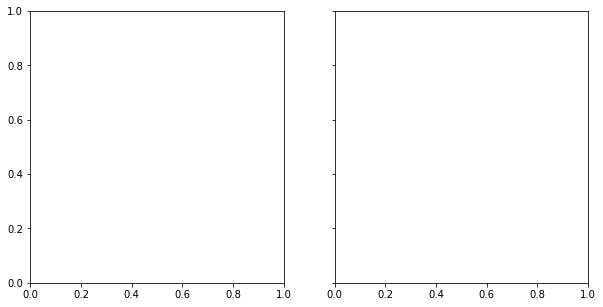

In [207]:
# Pick the time period of interest and average statistics over this period?
plt_start = pd.to_datetime(case_start)
plt_end = pd.to_datetime(case_end)


fig,ax = plt.subplots(ncols=2,figsize=(10,5),sharey=True)


varn = 'wspd'

#for dd,dom in enumerate(doms_of_interest):
for dd,dom in enumerate([2,3,5]):
    
    mean_ls = dom_dict[dom]['ls']
    ls = '-'
    
    dom_str = 'd0{}'.format(dom)
    ens_dom_ds = ens_dict[dom_str]
    data_toi = ens_dom_ds.sel(datetime=slice(plt_start,plt_end)).mean(dim='datetime')

    cases_of_interest_dom = cases_of_interest[0::4].copy()
    for cc,case in enumerate(cases_of_interest_dom):
        cases_of_interest_dom[cc] += '_{}'.format(dom_str)


    for cc,case in enumerate(cases_of_interest_dom):
        case_str = case.replace('_{}'.format(dom_str),'')

        if (dd == 0):
            plt_lbl = case_dict[case_str]['case_name']
        else:
            plt_lbl = None
        data_toi.sel(case=case,lidar=lid)[varn].plot(y='level',ax=ax[0],c=case_dict[case_str]['color'],ls=mean_ls,lw=2.0,label=plt_lbl)

    data_toi['ens_mean_{}'.format(varn)].sel(lidar=lid).plot(y='level',c='k',lw=4.0,ax=ax[0],ls=mean_ls,alpha=1.0)
    data_toi.sel(case='obs')[varn].sel(lidar=lid).plot(y='level',ax=ax[0],c='grey',ls=ls,lw=3.0)

    if dd == 0:
        err_str  = 'EME'
        sprd_str = 'Spread'
    else:
        err_str = None
        sprd_str = None

    if dom >= 3:
        spr_c = 'darkred'
        err_c = 'darkblue'
    else:
        spr_c = 'r'
        err_c = 'b'
        
    data_toi['ens_error_{}'.format(varn)].sel(lidar=lid).plot(y='level',c=err_c,ax=ax[1],label=err_str,ls=mean_ls,lw=2.0)
    data_toi['ens_spread_{}'.format(varn)].sel(lidar=lid).plot(y='level',c=spr_c,ax=ax[1],label=sprd_str,ls=mean_ls,lw=2.0)
    for axi in range(0,2):
        ax[axi].tick_params(labelsize=16)
        ax[axi].set_ylabel('')
        ax[axi].set_xlabel('')
        ax[axi].set_title('')

    var_min = ens_ds[varn].min()
    var_max = ens_ds[varn].max()
    var_range = var_max - var_min
    #ax[0].set_xlim(var_min - var_range*0.1,var_max + var_range*0.1)
    var_min,var_max = 5,18
    ax[0].set_xlim(var_min,var_max)
    if varn == 'delT':
        var_str = '∆T'
    else:
        var_str = varn.upper()

    if dd == 0:
        ax[0].plot([-10,-11],[1,1],c='k',ls=ls,label='Obs.',lw=2.0)
    ax[0].plot([-10,-11],[1,1],c='k',ls=mean_ls,label=dom_str,lw=3.0)

    ax[0].set_ylabel('Height [m]',size=18)
    ax[1].set_xlim(-0.1,2.8)

ax[0].text(0.02,0.98,lid,size=22,va='top',transform=ax[0].transAxes)
ax[0].set_xlabel('Wind Speed [m s$^{-1}$]',size=16)
ax[1].set_xlabel('[m s$^{-1}$]',size=16)
ax[0].set_ylim(15,205)

ax[0].legend(loc=(-0.1,1.01),frameon=False,ncol=5,fontsize=16,handlelength=2.9)


# Complex legend...
leg_x = 1.01
leg_y = 0.7
ax[1].legend([("r","darkred"), ("b","darkblue")], ['Spread', 'EME'],
               handler_map={tuple: AnyObjectHandler()},ncol=1,fontsize=16,
               frameon=False,loc=(leg_x,leg_y),handletextpad=0.2,labelspacing=1.6)
ax[1].text(leg_x + 0.09,leg_y + 0.215,'Meso',c='r',ha='center',va='bottom',fontsize=14,
             transform = ax[1].transAxes)
ax[1].text(leg_x + 0.09,leg_y + 0.19,'LES',c='darkred',ha='center',va='top',fontsize=14,
             transform = ax[1].transAxes)

ax[1].text(leg_x + 0.09,leg_y + 0.065,'Meso',c='b',ha='center',va='bottom',fontsize=14,
             transform = ax[1].transAxes)
ax[1].text(leg_x + 0.09,leg_y + 0.04,'LES',c='darkblue',ha='center',va='top',fontsize=14,
             transform = ax[1].transAxes)

#ax[1].legend(frameon=False,loc=(0.55,0.55),fontsize=16,ncol=1)
plt.suptitle('Mean between {0:02d} and {1:02d} Z on {2}/{3}'.format(plt_start.hour,plt_end.hour,plt_start.month,plt_start.day),
             y=1.1,size=22)
plt.show()